In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import ConvexHull, convex_hull_plot_2d 
from source_draft import preprocess as prep

from scipy.stats import entropy
from Bio import SeqIO

In [2]:
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'font.size': 9})

In [3]:
# functional threshold based on (mean_func - 2*std_func):
resc_func = 0.84158931 # where does this number come from? See EDA_partial_rescue

In [4]:
# Natural sequences
merge_ds = pd.read_excel('data/20210908_natural_with_taxonomy.xls').iloc[:,1:]
in_training_set= pd.read_excel('../data/LibraryNatural.xls')['In Training Set']

nat_rm = merge_ds[in_training_set==1]
nat_rm = nat_rm.drop_duplicates(subset='Sequences')

SH3 = merge_ds['Sequences']
mmd_nat_coord = np.array(merge_ds[['MMD_z0','MMD_z1','MMD_z2']])
mmd_nat_coord_rm = nat_rm[['MMD_z0','MMD_z1','MMD_z2']]

RE_nat = nat_rm['norm_RE']

# define functional and nonfunctional natural (only trainin samples).
nat_df = nat_rm.copy()

func_nat_df = nat_df[nat_df.norm_RE > resc_func]
nonfunc_nat_df = nat_df[~(nat_df.norm_RE > resc_func)]


In [5]:
# Sanity check: make sure natural functional and nonfunctional numbers make sense...

print('Number of functional natural sho1s:', func_nat_df.shape[0])
print('Number of nonfunctional (non-rescuing + partial-rescuing) natural sho1s:', nonfunc_nat_df.shape[0])
 

Number of functional natural sho1s: 132
Number of nonfunctional (non-rescuing + partial-rescuing) natural sho1s: 5167


#### Plot Natural sequence embeddings in the latent space

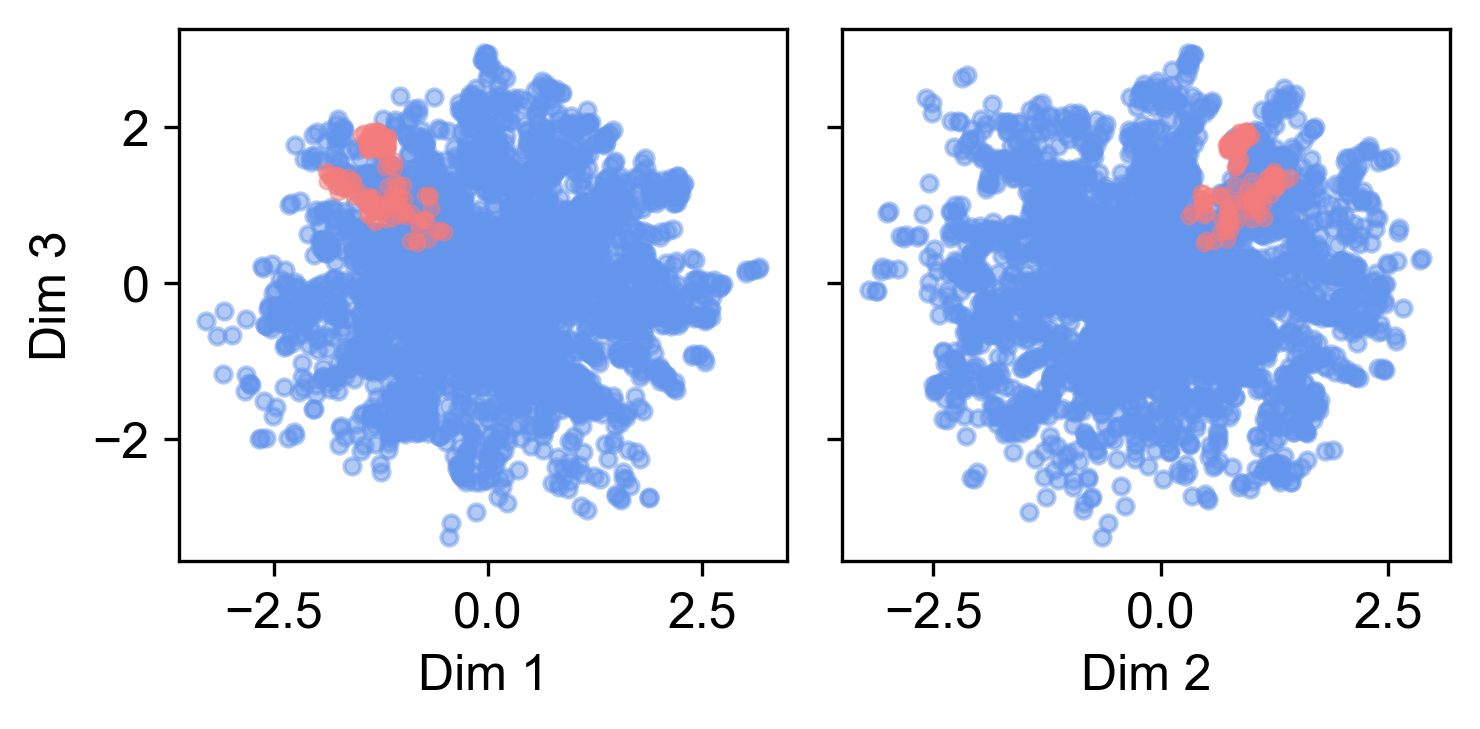

In [6]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams.update({'font.family': 'Arial'})

dsize = 1
size =15
lw=.5
bins = np.linspace(-2.5,2.5,25)

fig, axs = plt.subplots(1, 2, figsize = [5.0,2.5], sharex="col", sharey="row", dpi=300)





# nonfunctional latent embeddings

axs[0].scatter(
    nonfunc_nat_df[[f'MMD_z{ii}' for ii in range(3)]].values[:,0],
    nonfunc_nat_df[[f'MMD_z{ii}' for ii in range(3)]].values[:,2],
    s=size,
    c = 'cornflowerblue',
    alpha=.5
)

# functional natural sho1s 

axs[0].scatter(
    func_nat_df[[f'MMD_z{ii}' for ii in range(3)]].values[:,0],
    func_nat_df[[f'MMD_z{ii}' for ii in range(3)]].values[:,2],
    c = '#f47c7c',
    linewidth=lw,
    s = size,
    alpha=.5 
)


# -- Plot 2 ---



# nonfunctional latent embeddings

axs[1].scatter(
    nonfunc_nat_df[[f'MMD_z{ii}' for ii in range(3)]].values[:,1],
    nonfunc_nat_df[[f'MMD_z{ii}' for ii in range(3)]].values[:,2],
    s=size,
    c = 'cornflowerblue',
    alpha=.5
)

# functional natural sho1s 

axs[1].scatter(
    func_nat_df[[f'MMD_z{ii}' for ii in range(3)]].values[:,1],
    func_nat_df[[f'MMD_z{ii}' for ii in range(3)]].values[:,2],
    c = '#f47c7c',
    linewidth=lw,
    s = size,
    alpha=.5 
)



# subplot 0 ticks
axs[0].set_xticks([-2.5, 0, 2.5])
axs[0].set_yticks([-2, 0, 2])

# subplot 1 ticks
axs[1].set_xticks([-2.5, 0, 2.5])
axs[1].set_yticks([-2, 0, 2])
    
axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 3')
axs[1].set_xlabel('Dim 2')


plt.tight_layout(pad=.8)
#plt.savefig('./figures/Fig3D_natural_func_embeddings.svg', dpi = 300)
plt.show()

In [7]:
# upload design dataframe
design_sheet = pd.read_excel('../data/20220928_design_sheet.xlsx')
designed_seq = design_sheet['seq'][:11608].tolist()

# remove natural sequences based counts below 5...
filter1 = design_sheet['count_t0_ex1']<5
filter2 = design_sheet['count_t0_ex2']<5
above5_design_df = design_sheet[~(filter1|filter2)] # remove rows with counts below 5

# create design dataframe for each category:

# vae
VAE_global_df = above5_design_df[above5_design_df.header.str.contains('VAE_')]
VAE_local_df = above5_design_df[above5_design_df.header.str.contains('VAElocal_')]

# mmd 
MMD_global_df = above5_design_df[above5_design_df.header.str.contains('mmd_')]
MMD_local_df = above5_design_df[above5_design_df.header.str.contains('mmdlocal_')]

# bmdca
bmdca_df = above5_design_df[above5_design_df.header.str.contains('bmDCA')]

# sanity check: make sure dataframes are correct sizes
print(f'VAE Global and local sizes: {VAE_global_df.shape[0]} and {VAE_local_df.shape[0]}')
print(f'MMD-VAE Global and local sizes: {MMD_global_df.shape[0]} and {MMD_local_df.shape[0]}')
print(f'bmDCA size: {bmdca_df.shape[0]}')


VAE Global and local sizes: 3903 and 884
MMD-VAE Global and local sizes: 1972 and 964
bmDCA size: 3690


In [8]:
# partition on func and non-functional dataframes based on fully-rescuing threshold ...

# vae global sampled:
func_VAE_global_df = VAE_global_df[VAE_global_df.RE_norm >= resc_func]
nonfunc_VAE_global_df = VAE_global_df[~(VAE_global_df.RE_norm >= resc_func)]

# vae locally sampled:
func_VAE_local_df = VAE_local_df[VAE_local_df.RE_norm >= resc_func]
nonfunc_VAE_local_df = VAE_local_df[~(VAE_local_df.RE_norm >= resc_func)]


# mmd-VAE globally sampled:
func_MMD_global_df = MMD_global_df[MMD_global_df.RE_norm >= resc_func]
nonfunc_MMD_global_df = MMD_global_df[~(MMD_global_df.RE_norm >= resc_func)]


# mmd-VAE lcoally sampled:
func_MMD_local_df = MMD_local_df[MMD_local_df.RE_norm >= resc_func]
nonfunc_MMD_local_df = MMD_local_df[~(MMD_local_df.RE_norm >= resc_func)]


# bmDCA:
func_bmdca_df = bmdca_df[bmdca_df.RE_norm >= resc_func]
nonfunc_bmdca_df = bmdca_df[~(bmdca_df.RE_norm >= resc_func)]



In [9]:
# sanity check:
# make sure the number of functional and non-functional sequences is accurate ...

# VAE numbers
print(f'Functional and nonfunctional VAE global size: {func_VAE_global_df.shape[0]} and {nonfunc_VAE_global_df.shape[0]}')
print(f'Functional and nonfunctional VAE local size: {func_VAE_local_df.shape[0]} and {nonfunc_VAE_local_df.shape[0]}')


print(f'\nFunctional and nonfunctional MMD-VAE global size: {func_MMD_global_df.shape[0]} and {nonfunc_MMD_global_df.shape[0]}')
print(f'Functional and nonfunctional MMD-VAE local size: {func_MMD_local_df.shape[0]} and {nonfunc_MMD_local_df.shape[0]}')

print(f'\nFunctional and nonfunctional bmDCA size: {func_bmdca_df.shape[0]} and {nonfunc_bmdca_df.shape[0]}')


Functional and nonfunctional VAE global size: 22 and 3881
Functional and nonfunctional VAE local size: 158 and 726

Functional and nonfunctional MMD-VAE global size: 35 and 1937
Functional and nonfunctional MMD-VAE local size: 433 and 531

Functional and nonfunctional bmDCA size: 0 and 3690


## Taxonomy figures

In [10]:
ortho_list = merge_ds['orthologous_group'].tolist()
u_o = np.unique(ortho_list)[:-1]
cdict=np.arange(len(u_o))

z_x, z_y = [0,0,1], [1,2,2]

In [11]:
phylogeny = ['Saccharomycotina', 'Pezizomycotina', 'Basidiomycota']

merge_ds['PhyGroup'] = np.nan
for j in range(len(phylogeny)):
    filter_1 = merge_ds['Phylogeny'].str.contains(phylogeny[j])
    merge_ds.loc[filter_1,'PhyGroup'] = phylogeny[j]

nodik = 'non-Dikarya fungi'
phylogeny.append(nodik)
filter_2 = ~merge_ds['Phylogeny'].str.contains('Dikarya')
filter_3 = merge_ds['Phylogeny'].str.contains('Fungi')
merge_ds.loc[filter_2 & filter_3,'PhyGroup'] = nodik

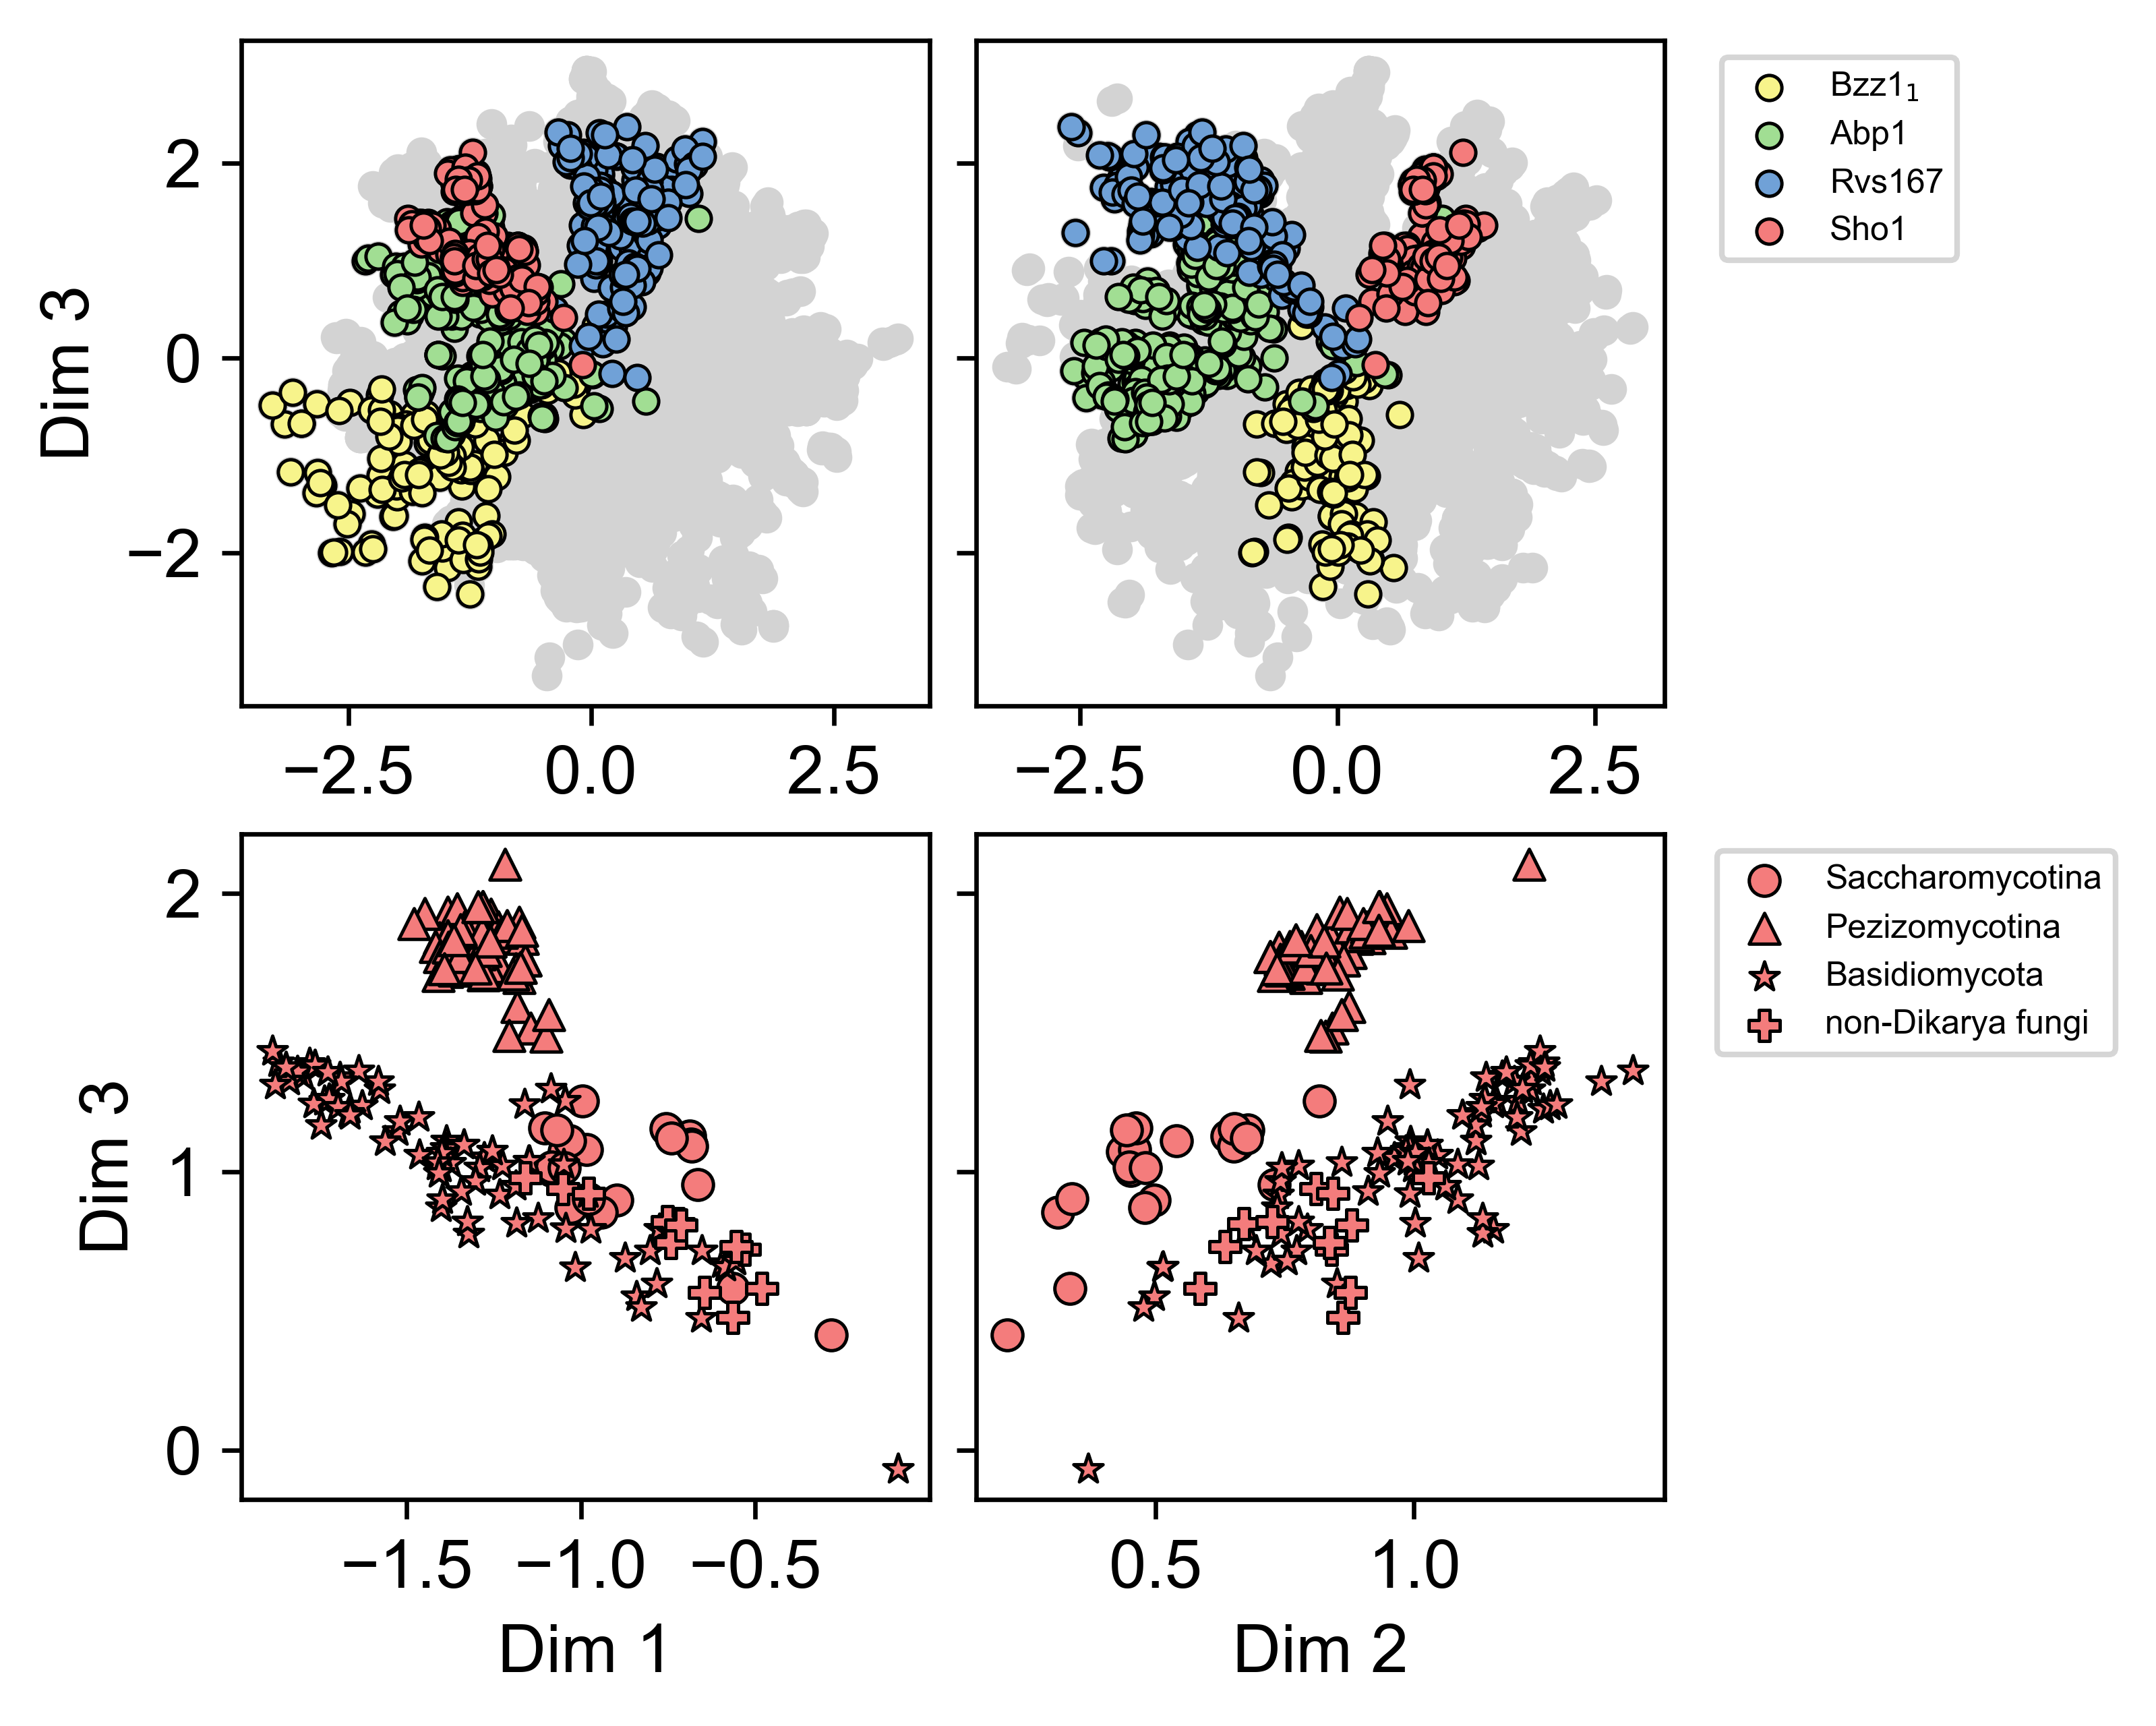

In [12]:
# Classify orthology and phylogeny for four typical paralogs including Sho1

fig, ax = plt.subplots(2,2,figsize=(5.4,4.2),
                       gridspec_kw=dict(height_ratios=[2,2],width_ratios=[2,2]),dpi=600)
for j in range(2):
    ax[0,j].scatter(mmd_nat_coord[:,j], mmd_nat_coord[:,2], c = 'lightgray', s = 20)
    ax[j,0].set_ylabel('Dim 3')
    for g in range(4):
        ix = np.where(np.array(ortho_list) == ['KOG3565_1','KOG3655','KOG3771','NOG09120'][g])[0]
        ax[0,j].scatter(mmd_nat_coord[ix,j], mmd_nat_coord[ix,2],
                        c = ['#f7f48b','#a1de93','#70a1d7','#f47c7c'][g], 
                        label = [r'Bzz1$_{1}$','Abp1','Rvs167','Sho1'][g], edgecolor = 'k', linewidth=0.6,s = 20)
        
        ix = np.where((merge_ds['PhyGroup'] == phylogeny[g]) & (merge_ds['orthologous_group'] == 'NOG09120'))[0]
        ax[1,j].scatter(mmd_nat_coord[ix,j], mmd_nat_coord[ix,2], 
                        marker = ['o','^','*','P'][g], c = '#f47c7c',
                        label = phylogeny[g], edgecolor = 'k', linewidth=0.6,s = 30)
        
ax[0,1].legend(loc='upper right', bbox_to_anchor=(1.45, 1),fontsize=6)
ax[1,1].legend(loc='upper right', bbox_to_anchor=(1.68, 1),fontsize=6)
ax[1,0].set_xlabel('Dim 1')
ax[1,1].set_xlabel('Dim 2')
plt.setp(ax[0,1].get_yticklabels(), visible=False)
plt.setp(ax[1,1].get_yticklabels(), visible=False)
plt.tight_layout(pad=.4)
#plt.savefig('../VAE_design_paper/Fig1/latent_3.svg')
plt.show()

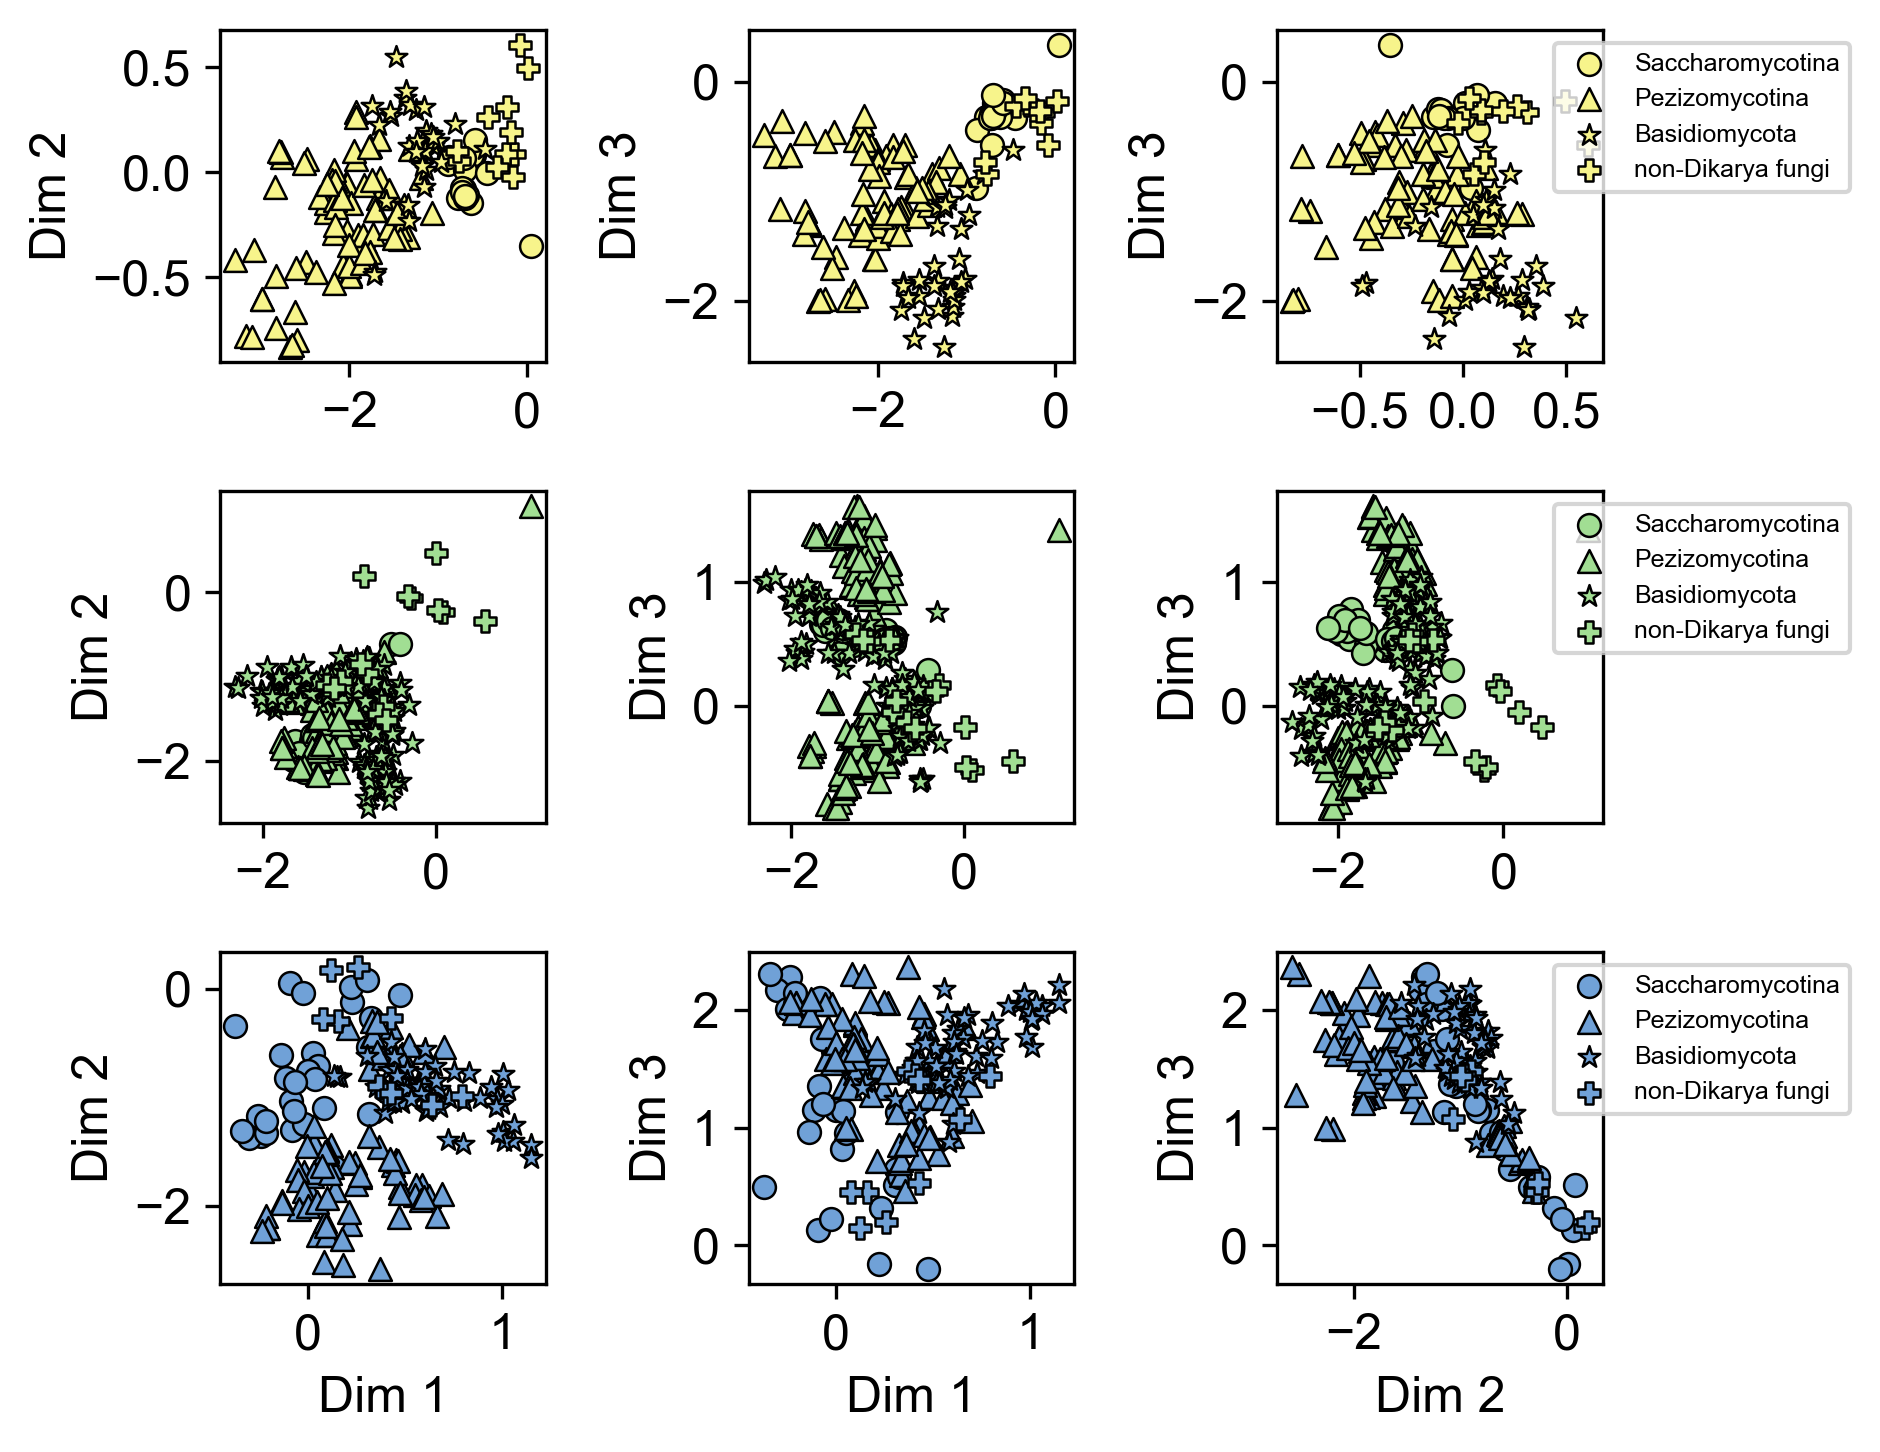

In [13]:
# Phylogeny structure for the four groups

fig, ax = plt.subplots(3,3,figsize=(6.8,5),dpi=300)
for j in range(3):
    ax[2,j].set_xlabel('Dim '+ str(z_x[j]+1))
    for i in range(3):
        ax[j,i].set_ylabel('Dim ' + str(z_y[i]+1))
        for g in range(4):
            ix = np.where((merge_ds['PhyGroup'] == phylogeny[g]) & (merge_ds['orthologous_group'] == 
                                                             ['KOG3565_1','KOG3655','KOG3771'][j]))[0]
            ax[j,i].scatter(mmd_nat_coord[ix, z_x[i]], mmd_nat_coord[ix, z_y[i]], 
                            marker = ['o','^','*','P'][g], c = ['#f7f48b','#a1de93','#70a1d7'][j],
                            label = phylogeny[g], edgecolor = 'k',linewidth=0.6,s = 30)        
    ax[j,2].legend(loc='upper right', bbox_to_anchor=(1.8, 1),fontsize=6)
plt.tight_layout()
#plt.savefig('figures/phy.pdf')
plt.show()

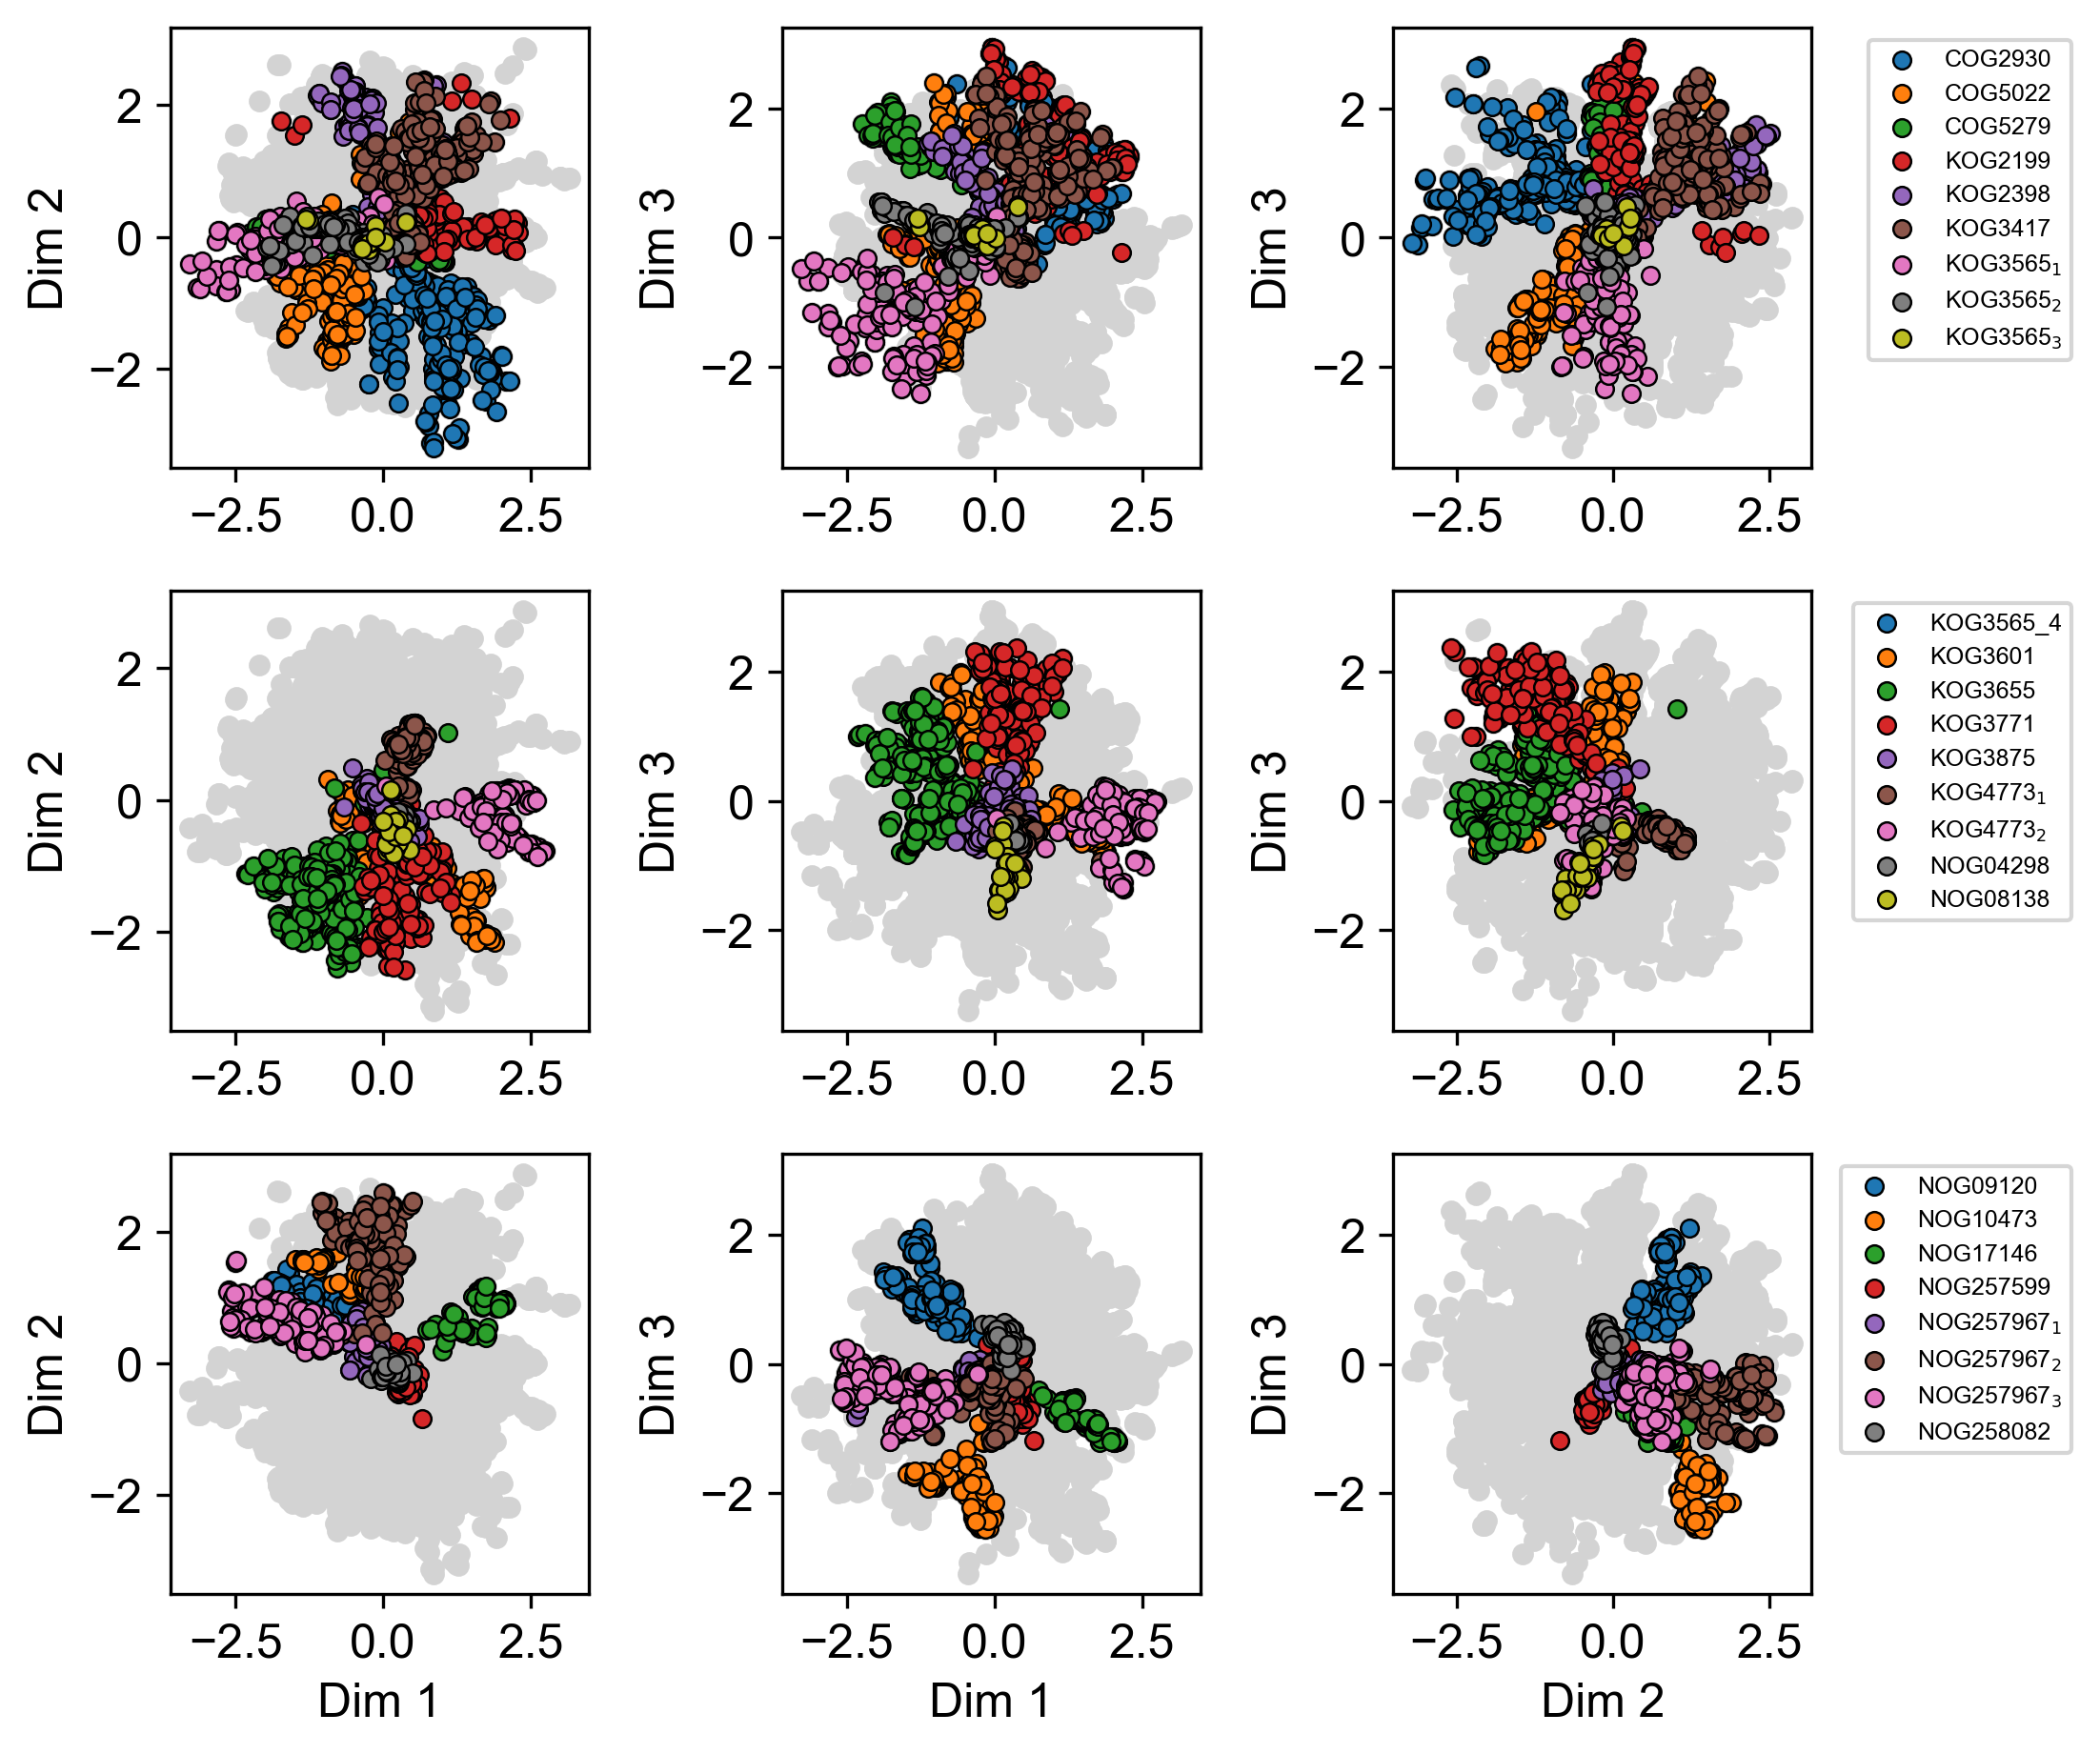

In [14]:
# Orthology structure for all 24 paralogs

u_o_update = u_o
for i in range(1,4):
    u_o_update = [j.replace('_%d'%i,'$_%d$'%i) for j in u_o_update]

fig, ax = plt.subplots(3,3,figsize=(7.5,6.3),dpi=300)
c_list = [np.arange(9),np.arange(9,18),np.arange(18,26)]

for i in range(3):
    ax[2,i].set_xlabel('Dim '+ str(z_x[i]+1))
    for j in range(3):
        ax[i,j].set_ylabel('Dim '+ str(z_y[j]+1))
        ax[i,j].scatter(mmd_nat_coord[:,z_x[j]], mmd_nat_coord[:,z_y[j]], c = 'lightgray', s = 20)
        for g in cdict[9*i:9*(i+1)]:
            ix = np.where(np.array(ortho_list) == u_o[g])[0]
            ax[i,j].scatter(mmd_nat_coord[ix,z_x[j]], mmd_nat_coord[ix,z_y[j]], 
                            label = u_o_update[g], edgecolor = 'k', s = 20, linewidth=0.6)
    ax[i,2].legend(loc='upper right', bbox_to_anchor=(1.65, 1), fontsize=6)

    plt.tight_layout()
plt.show()

In [15]:
phylogeny = ['Saccharomycotina', 'Pezizomycotina', 'Basidiomycota']
phy_list_mmd = []
for j in range(len(phylogeny)):
    filter_4 = merge_ds['Phylogeny'].str.contains(phylogeny[j])
    phy_list_mmd.append(np.array(mmd_nat_coord[filter_4]))
phylogeny.append('non-Dikarya fungi')
phy_list_mmd.append(np.array(mmd_nat_coord[filter_2 & filter_3]))

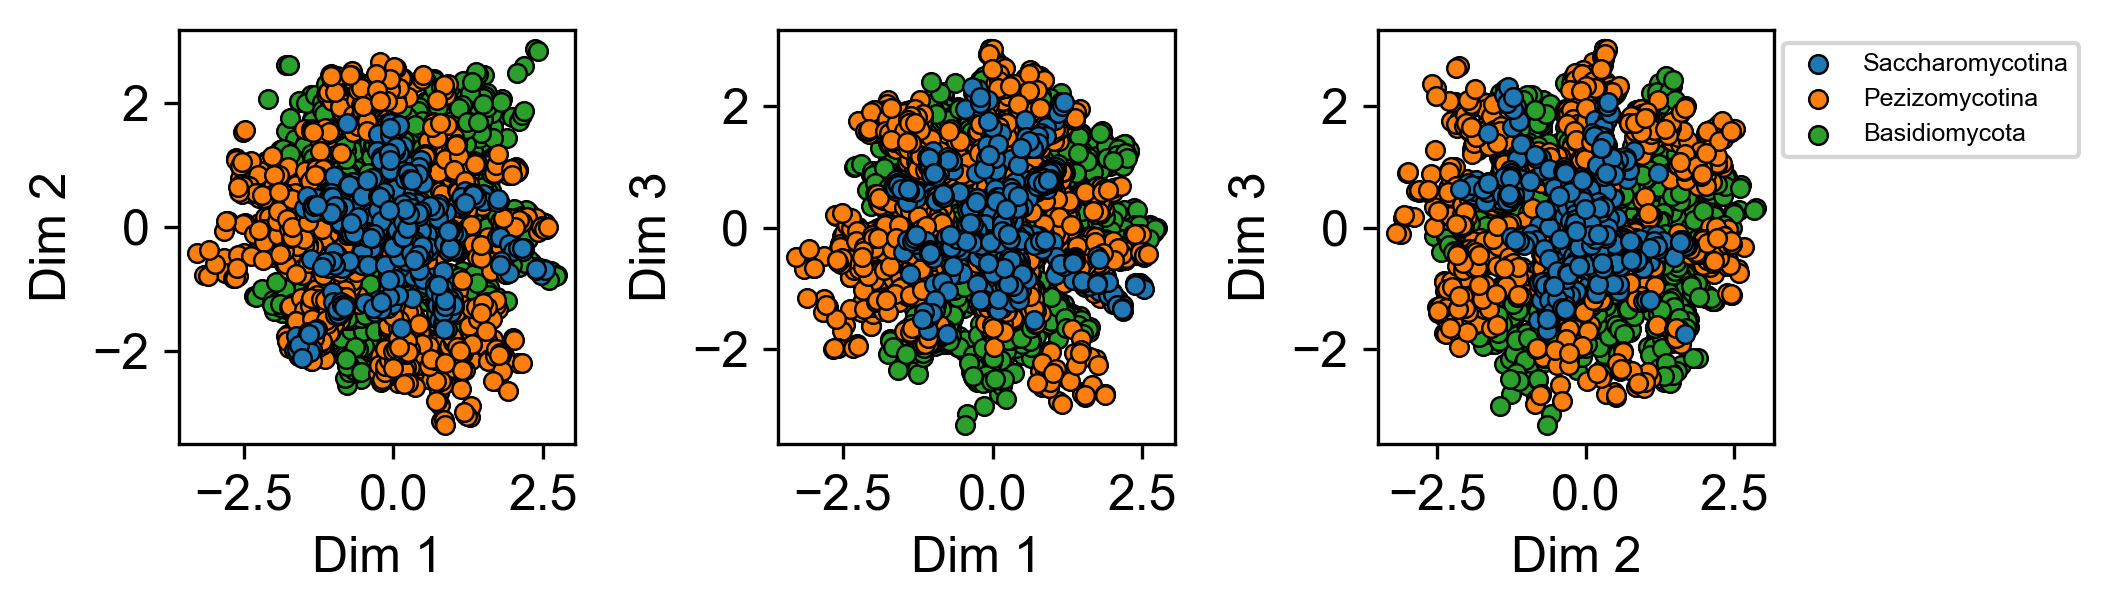

In [16]:
fig, ax = plt.subplots(1,3,figsize=(7.5,2.2),dpi=300)
for i in range(3):
    ax[i].set_xlabel('Dim '+ str(z_x[i]+1))
    ax[i].set_ylabel('Dim '+ str(z_y[i]+1))
    for j in [0,1,2]:
        ax[i].scatter(phy_list_mmd[j][:,z_x[i]], phy_list_mmd[j][:,z_y[i]], 
                      label = phylogeny[j], edgecolor = 'k',s = 20 ,linewidth=0.6, zorder = 3-j)
ax[2].legend(loc='upper right', bbox_to_anchor=(1.8, 1),fontsize=6)
plt.tight_layout()
plt.show()

In [17]:
phylogeny = ['Saccharomyces cerevisiae', 'Saccharomycetaceae', 'Pezizomycotina', 'Basidiomycota']
phy_list_mmd = []

filter_2 = ~merge_ds['Phylogeny'].str.contains('Dikarya')
filter_3 = merge_ds['Phylogeny'].str.contains('Fungi')

for j in range(len(phylogeny)):
    filter_4 = merge_ds['Phylogeny'].str.contains(phylogeny[j])
    phy_list_mmd.append(np.array(mmd_nat_coord[filter_4]))
    
phylogeny.append('non-Dikarya fungi')
phy_list_mmd.append(np.array(mmd_nat_coord[filter_2 & filter_3]))

phylogeny.append('non-fungi')
phy_list_mmd.append(np.array(mmd_nat_coord[~filter_3]))

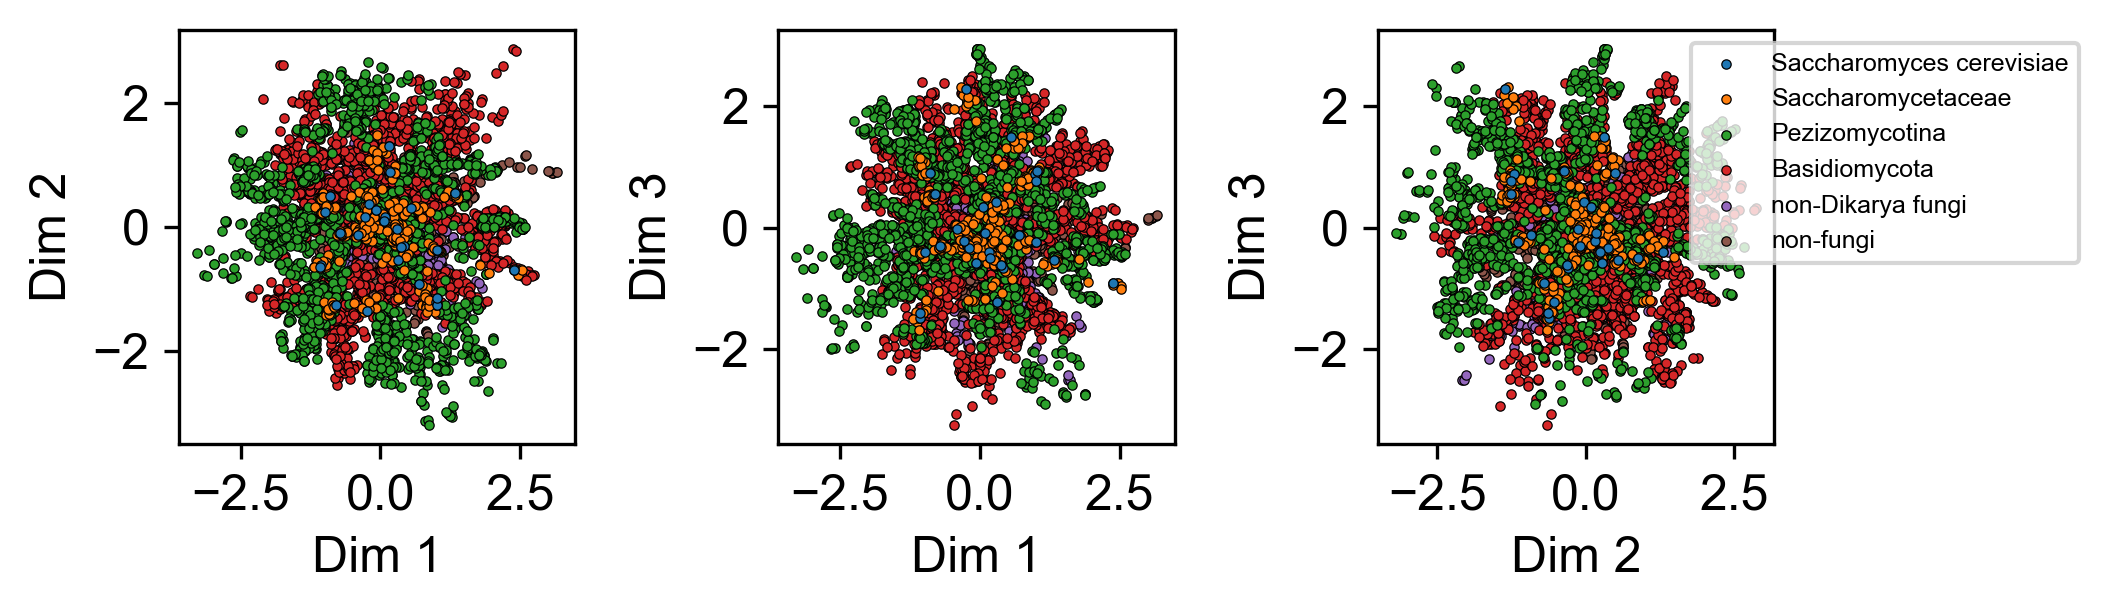

In [18]:
fig, ax = plt.subplots(1,3,figsize=(7.5,2.2),dpi=300)
for i in range(3):
    ax[i].set_xlabel('Dim '+ str(z_x[i]+1))
    ax[i].set_ylabel('Dim '+ str(z_y[i]+1))
    for j in [0,1,2,3,4,5]:
        ax[i].scatter(phy_list_mmd[j][:,z_x[i]], phy_list_mmd[j][:,z_y[i]], 
                      label = phylogeny[j], edgecolor = 'k',s = 5 ,linewidth=0.3, zorder = 5-j)
ax[2].legend(loc='upper right', bbox_to_anchor=(1.8, 1),fontsize=6)
plt.tight_layout()
plt.show()

## Plot Figure 4A (with phylogeny of natural Sho1-SH3 sequences)
* **Red**: natural sequences and phylogeny (Markers are the same as Figure 1D)
* **Yellow**: Functional infoVAEdesigned sequences. (They fill gaps between natural sequences.)
* **Blue**: Unfunctional infoVAE designed sequences.

In [19]:
phylogeny = ['Saccharomycotina', 'Pezizomycotina', 'Basidiomycota']
phy_list_mmd = []
for j in range(len(phylogeny)):
    filter_4 = merge_ds['Phylogeny'].str.contains(phylogeny[j])
    phy_list_mmd.append(np.array(mmd_nat_coord[filter_4]))
phylogeny.append('non-Dikarya fungi')
phy_list_mmd.append(np.array(mmd_nat_coord[filter_2 & filter_3]))

#### Plotting natural functional on top of  MMD-VAE embeddings (Figure 5A):

Important to note... We are plotting InfoVAE embeddings and not all synthetic embeddings based on the draft figure caption. 

In [20]:
# all of the functional mmd sequences (global versus local)
func_MMD_z = pd.concat((func_MMD_global_df, func_MMD_local_df), axis = 0)[[f'MMD_z{ii}' for ii in range(3)]].values
print('Number of functional MMD sequences:', func_MMD_z.shape[0])

nonfunc_MMD_z = pd.concat((nonfunc_MMD_global_df, nonfunc_MMD_local_df), axis = 0)[[f'MMD_z{ii}' for ii in range(3)]].values
print('Number of nonfunctional MMD sequences:', nonfunc_MMD_z.shape[0])


Number of functional MMD sequences: 468
Number of nonfunctional MMD sequences: 2468


In [21]:
# Verify the numbers of natural sho1s embedded in the latent space. 

total_num_nat_plot = 0 # number of natural sho1s plotting in figure 5A.
for g in range(4):
        
    # plot pink natural embedding in shapes
    ix = np.where((merge_ds['PhyGroup'] == phylogeny[g]) & (merge_ds['orthologous_group'] == 'NOG09120'))[0]

    print(f'Number of {phylogeny[g]} Sho1s:', mmd_nat_coord[ix,:].shape[0])
    total_num_nat_plot += mmd_nat_coord[ix,:].shape[0]
    
print('\nNumber of plotted sho1s:', total_num_nat_plot)

Number of Saccharomycotina Sho1s: 22
Number of Pezizomycotina Sho1s: 62
Number of Basidiomycota Sho1s: 76
Number of non-Dikarya fungi Sho1s: 12

Number of plotted sho1s: 172


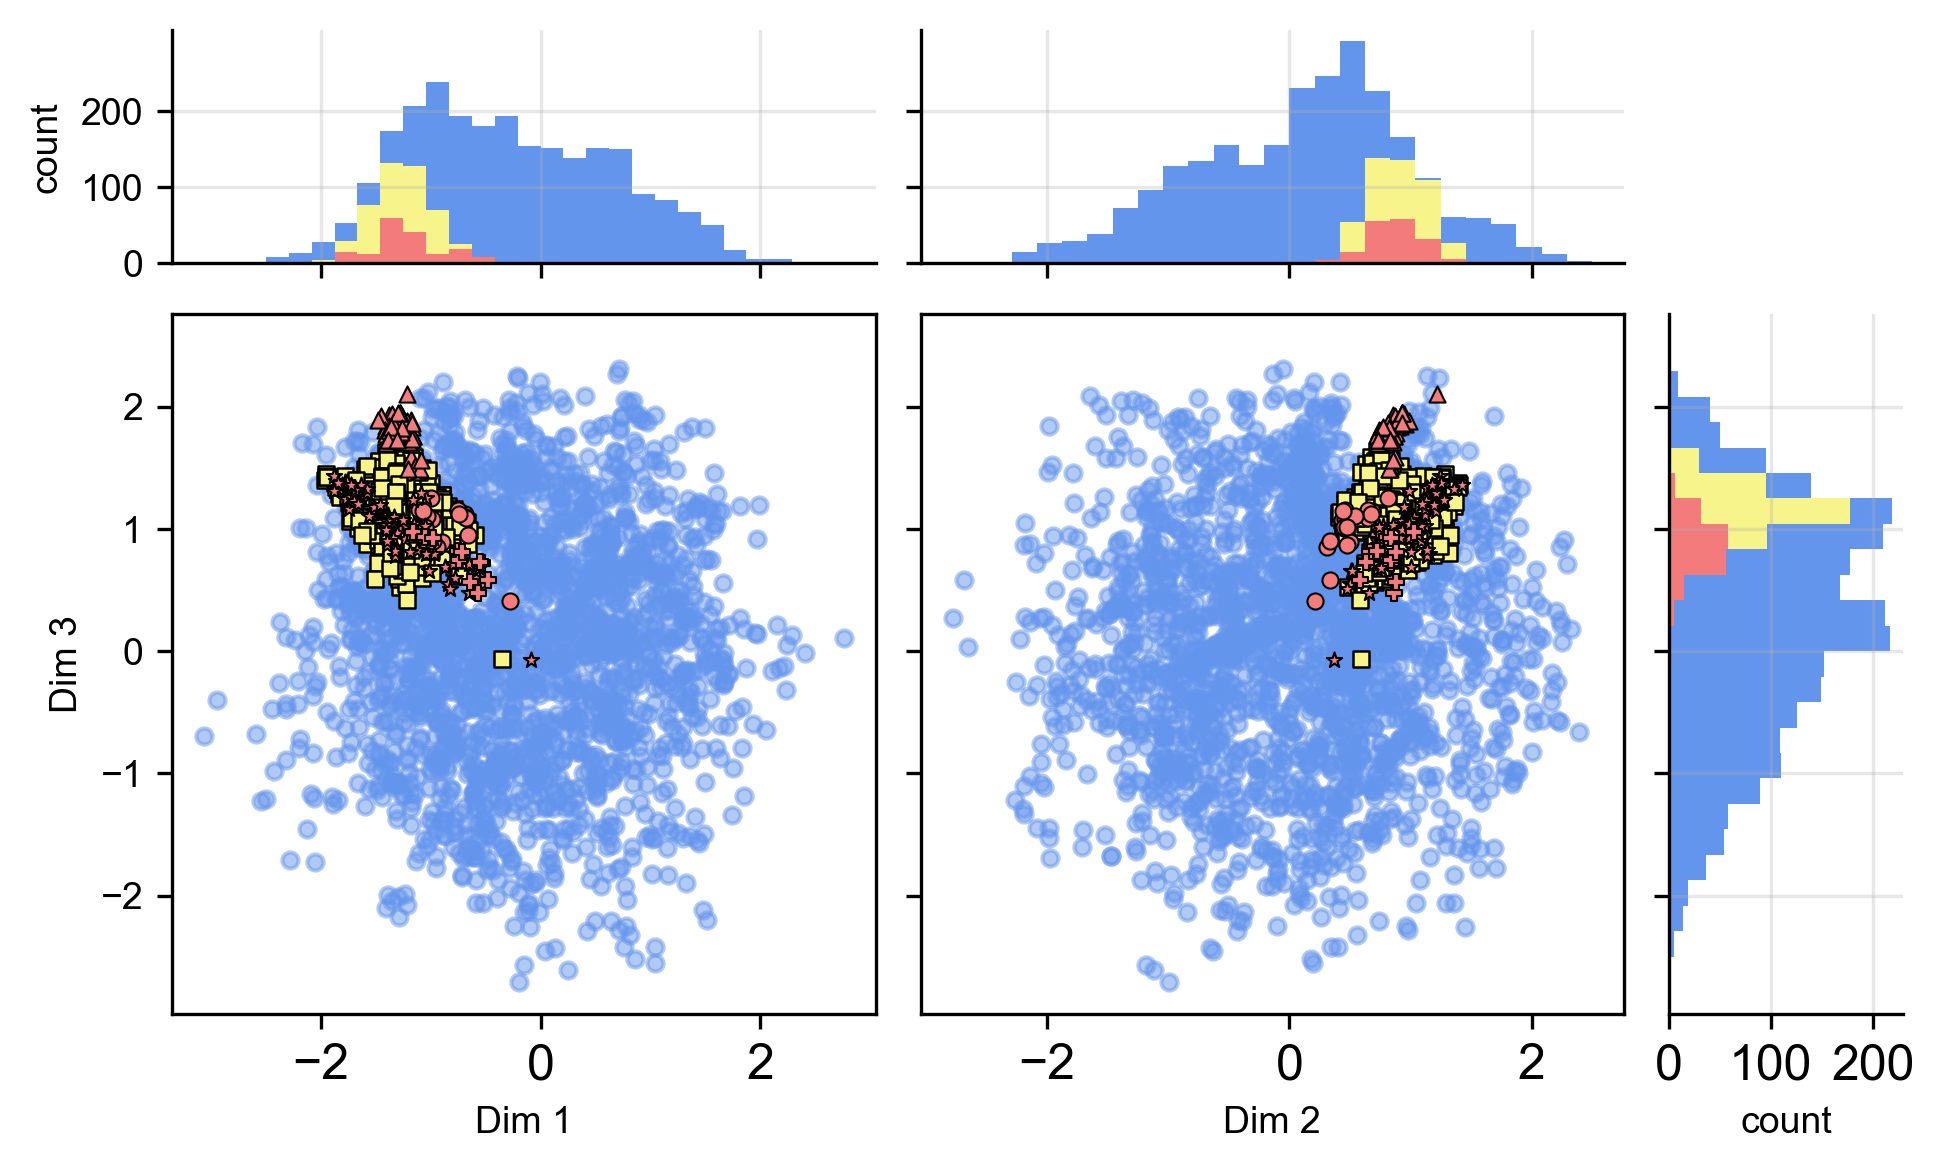

In [22]:
plt.rcParams.update({'font.size': 9})
dsize = 1
size =15
lw=.5
bins = np.linspace(-2.5,2.5,25)

fig, axs = plt.subplots(2,3,figsize = [6.5,3.9], sharex="col", sharey="row",
                         gridspec_kw=dict(height_ratios=[1,3],width_ratios=[3,3,1]),dpi=300)
axs[0, 2].set_visible(False)

for i in range(2):
    
    
    # plot non-functional InfoVAE embeddings
    
    axs[1,i].scatter(
        nonfunc_MMD_z[:,i],
        nonfunc_MMD_z[:,2],
        s=size,
        c = 'cornflowerblue',
        alpha=.5
    )
    
    # plot functional InfoVAE embeddings

    axs[1,i].scatter(
        func_MMD_z[:,i],
        func_MMD_z[:,2],
        s=size,
        c = '#F7F48B',
        linewidth=0.6,
        edgecolor='k',
        marker='s'
    )
    
    for g in range(4):
        
        # plot pink natural embedding in shapes
        ix = np.where((merge_ds['PhyGroup'] == phylogeny[g]) & (merge_ds['orthologous_group'] == 'NOG09120'))[0]
        axs[1,i].scatter(
            mmd_nat_coord[ix,i],
            mmd_nat_coord[ix,2],
            marker = ['o','^','*','P'][g],
            c = '#f47c7c',
            edgecolor = 'k',
            linewidth=lw,
            s = size
        )
    
    
    # plot InfoVAE histograms ...
    axs[0,i].hist(
        nonfunc_MMD_z[:,i],
        bins,
        color = 'cornflowerblue',
    )
    axs[0,i].hist(
        func_MMD_z[:,i],
        bins,
        color = '#F7F48B'
    )
    
    # plot natural histograms

    
    # axs[0,i].hist(mmd_nat_coord[good_nat,i],bins, color = '#f47b7b') # DO NOT PLOT ALL FUNCTIONAL natural!!
    axs[0,i].hist(
        mmd_nat_coord[merge_ds['orthologous_group'] == 'NOG09120',i],
        bins,
        color = '#f47b7b'
    )
    
    
    axs[0,i].grid(alpha=.3)
    axs[0,i].spines['right'].set_visible(False)
    axs[0,i].spines['top'].set_visible(False)
    axs[0,i].set_yticks([0,100,200])

# plot InfoVAE histograms
axs[1,2].hist(
    nonfunc_MMD_z[:,2],
    bins,
    orientation='horizontal',
    color = 'cornflowerblue'
)
axs[1,2].hist(
    func_MMD_z[:,2],
    bins,
    orientation='horizontal',
    color = '#F7F48B'
)


# plot natural histograms
axs[1,2].hist(
    mmd_nat_coord[merge_ds['orthologous_group'] == 'NOG09120',i],
    bins,
    orientation='horizontal',
    color = '#f47b7b'
)

axs[1,2].spines['right'].set_visible(False)
axs[1,2].spines['top'].set_visible(False)
axs[1,2].set_xticks([0,100,200])
axs[1,2].grid(alpha=.3)
    
axs[1,0].set_xlabel('Dim 1')
axs[1,0].set_ylabel('Dim 3')
axs[1,1].set_xlabel('Dim 2')
axs[0,0].set_ylabel('count')
axs[1,2].set_xlabel('count')

plt.tight_layout(pad=.8)
plt.show()

## Define convex hull functions.

In [23]:
def compute_hull(data, hull):
    ix = np.where(data == hull)[0]
    coord = mmd_nat_coord[ix,:]
    return ConvexHull(coord)

def check_latent_in_hull(z_coord, hull, tolerance = 10**-12):
    decision = all((np.dot(equa[:-1], z_coord) + equa[-1] <= tolerance) for equa in hull.equations)
    return decision

def check_hull_list(l, hull):
    return np.array([check_latent_in_hull(i, hull) for i in l])

def freq_mat(heatmap_list):
    frequence = np.zeros([21, 59])
    listseq = np.array([list(i) for i in heatmap_list])
    for num, i in enumerate('-ACDEFGHIKLMNPQRSTVWY'):
        for j in range(59):
            frequence[num,j] = np.count_nonzero(listseq[:,j]==i)/len(heatmap_list)
    return(frequence)

def compute_entropy(seq):
    return entropy(freq_mat(seq),base=2)

## Functional Sho1 hull

In [24]:
# sanity check: Number of functional and non-functional sho1s. 
print('Number of functional Sho1 orthologs:', func_nat_df.shape[0])
print('Number of non-functional Sho1 orthologs:', nonfunc_nat_df.shape[0])


Number of functional Sho1 orthologs: 132
Number of non-functional Sho1 orthologs: 5167


In [25]:
# all of these sequences are functonal sho1s
func_nat_z = func_nat_df[[f'MMD_z{ii}' for ii in range(3)]].values

In [26]:
print(
    'How many sequences are left after pruning outliers:',
     sum(func_nat_z[:,0] < -.4),
     sum(func_nat_z[:,1] > 0.),
     )

How many sequences are left after pruning outliers: 132 132


In [28]:
ortho_mmd = np.array(func_nat_z)

# notel: we actual remove no outliers when we use 2*std deviations...
#ortho_mmd = ortho_mmd[ortho_mmd[:,0] < -.4, :] # remove outliers
#ortho_mmd = ortho_mmd[ortho_mmd[:,1] > 0., :]

# create convex hull based on functional natural sho1s (# 132)
ortho_hull = ConvexHull(ortho_mmd)

In [29]:
# check how many natural SH3 domains are in the convex hull

class_nat = check_hull_list(
    nat_df[[f'MMD_z{ii}' for ii in range(3)]].values,
    ortho_hull
)

print(f'Number of natural SH3 domains in the functional Sho1 convex hull: {sum(class_nat)}')


# check how many functinonal natural Sh3s are in the convex hull
func_class_nat = check_hull_list(
    func_nat_df[[f'MMD_z{ii}' for ii in range(3)]].values,
    ortho_hull
)
print(f'Number of functional SH3 domains in the convex hull: {sum(func_class_nat)}')

# check how many nonfunctinonal natural Sh3s (training dataset only) are in the convex hull

nonfunc_class_nat = check_hull_list(
    nonfunc_nat_df[[f'MMD_z{ii}' for ii in range(3)]].values,
    ortho_hull
)
print(f'Number of functional SH3 domains in the convex hull: {sum(nonfunc_class_nat)}')



Number of natural SH3 domains in the functional Sho1 convex hull: 155
Number of functional SH3 domains in the convex hull: 132
Number of functional SH3 domains in the convex hull: 23


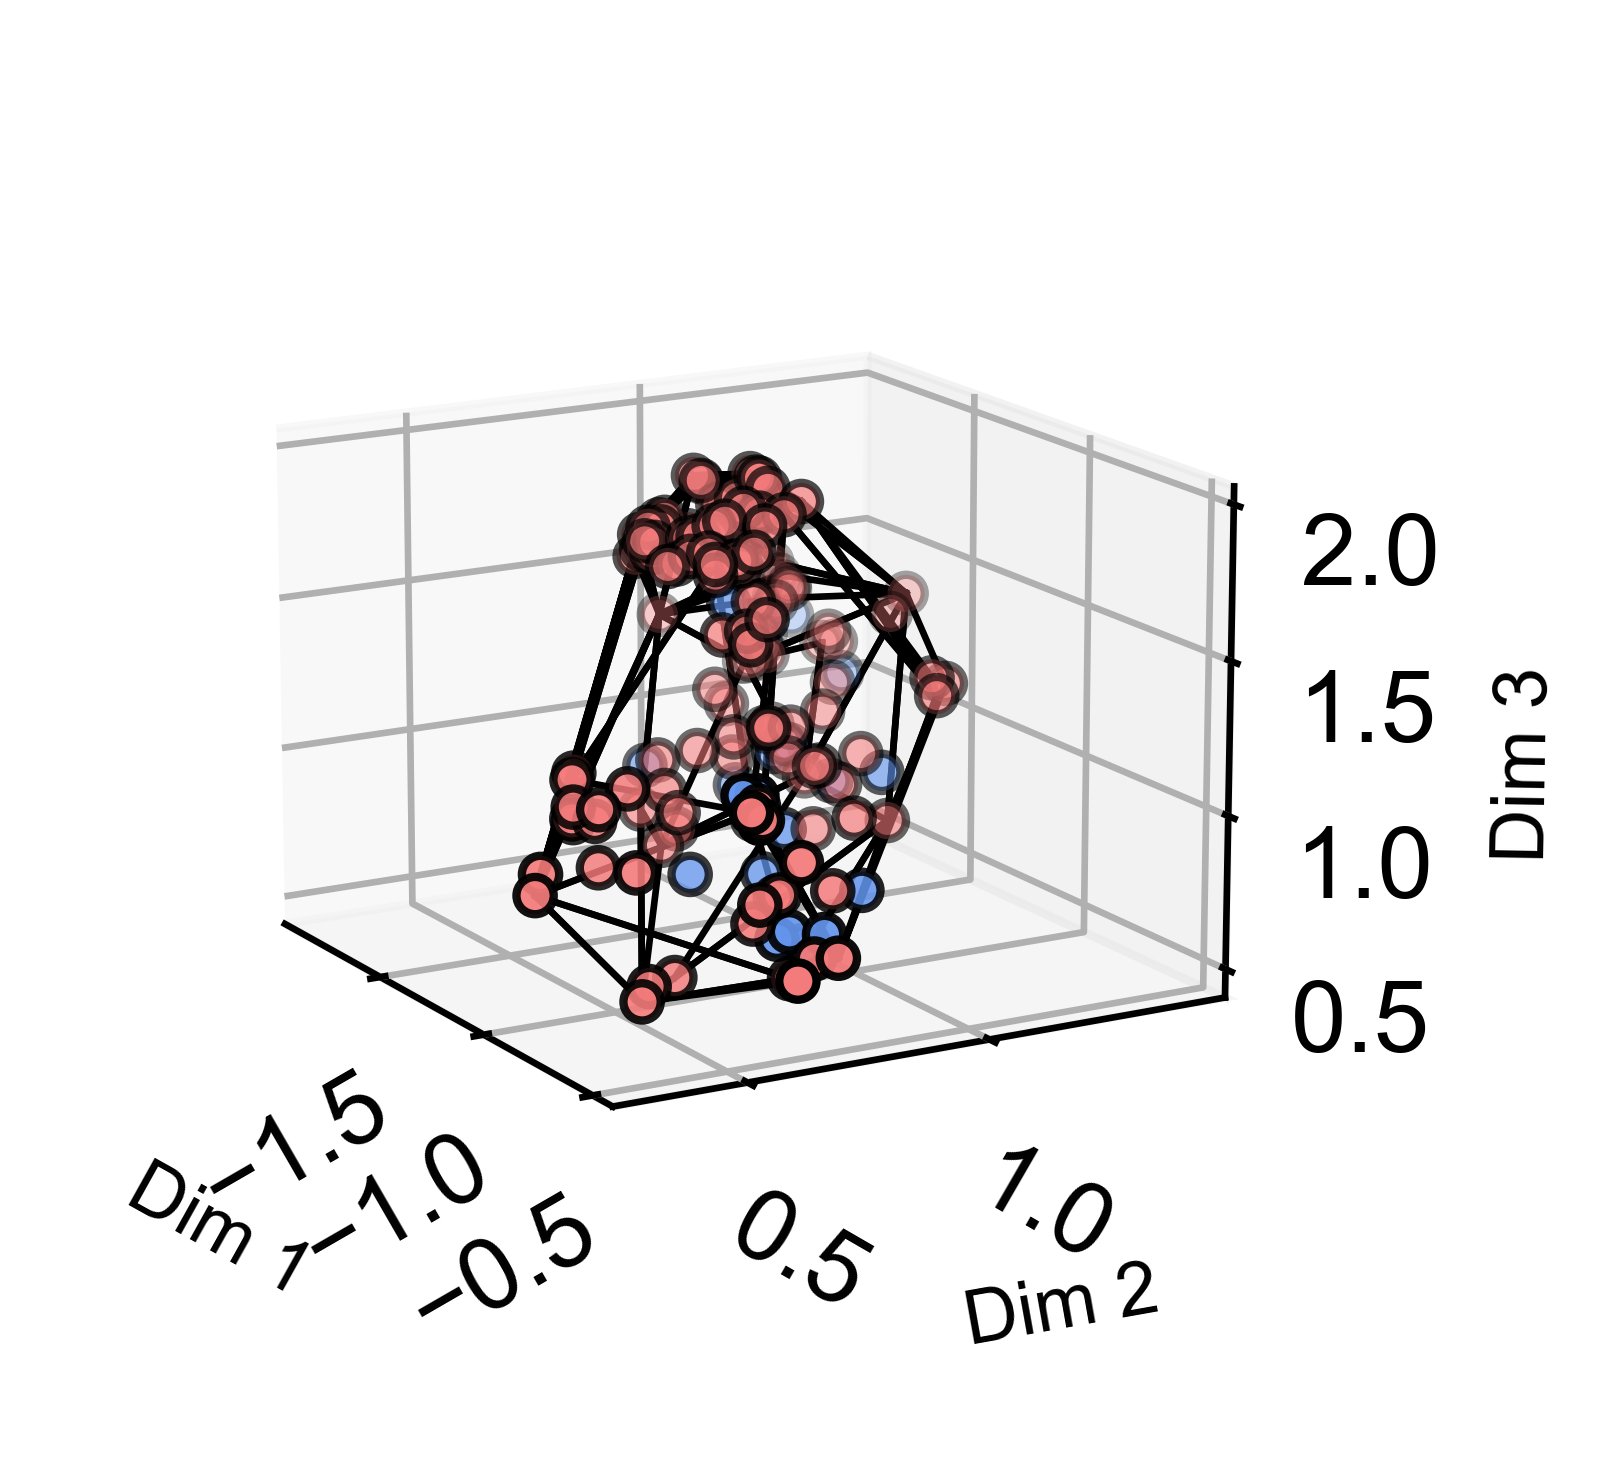

In [30]:
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)

    # plot all of the nonfunctional embeddings in the convex hull ...
    
    p = ax.scatter(
        nonfunc_nat_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[nonfunc_class_nat, 0],
        nonfunc_nat_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[nonfunc_class_nat, 1],
        nonfunc_nat_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[nonfunc_class_nat, 2],
        c = 'cornflowerblue', 
        edgecolor = 'k', 
        s = 20
    )
                   
        
    
    # plot all of the functional embeddings in the convex hull ...
    p = ax.scatter(
        func_nat_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[func_class_nat,0],
        func_nat_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[func_class_nat,1], 
        func_nat_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[func_class_nat,2],
        c='#f47b7b',
        edgecolor = 'k',
        s = 20
    )

    

    for simplex in ortho_hull.simplices:
        ax.plot(ortho_mmd[simplex, 0], ortho_mmd[simplex, 1],  ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()
#plt.savefig('figures/b.pdf')

In [31]:
#good_des_mmd_local_coor = design_mmd[np.intersect1d(mmd_local,good_des_mmd)]
#nogood_des_mmd_local_coor = design_mmd[np.intersect1d(mmd_local,no_good_des_mmd)]

#good_des_mmd_local_coor_plot = good_des_mmd_local_coor
#fdp_o = check_hull_list(good_des_mmd_local_coor_plot,ortho_hull) 

#fdp = check_hull_list(good_des_mmd_local_coor,ortho_hull) 
#ufdp = check_hull_list(nogood_des_mmd_local_coor,ortho_hull) 

#nogood_des_mmd_local_coor_plot = nogood_des_mmd_local_coor
#ufdp_o = check_hull_list(nogood_des_mmd_local_coor_plot,ortho_hull) 

In [33]:
# functional local InfoVAE embeddings w/in convex hull ...

func_MMD_local_in_hull = check_hull_list(
    func_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].values,
    ortho_hull
)

# nonfunctional local InfoVAE embeddings w/in convex hull ...
nonfunc_MMD_local_in_hull = check_hull_list(
    nonfunc_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].values,
    ortho_hull
)

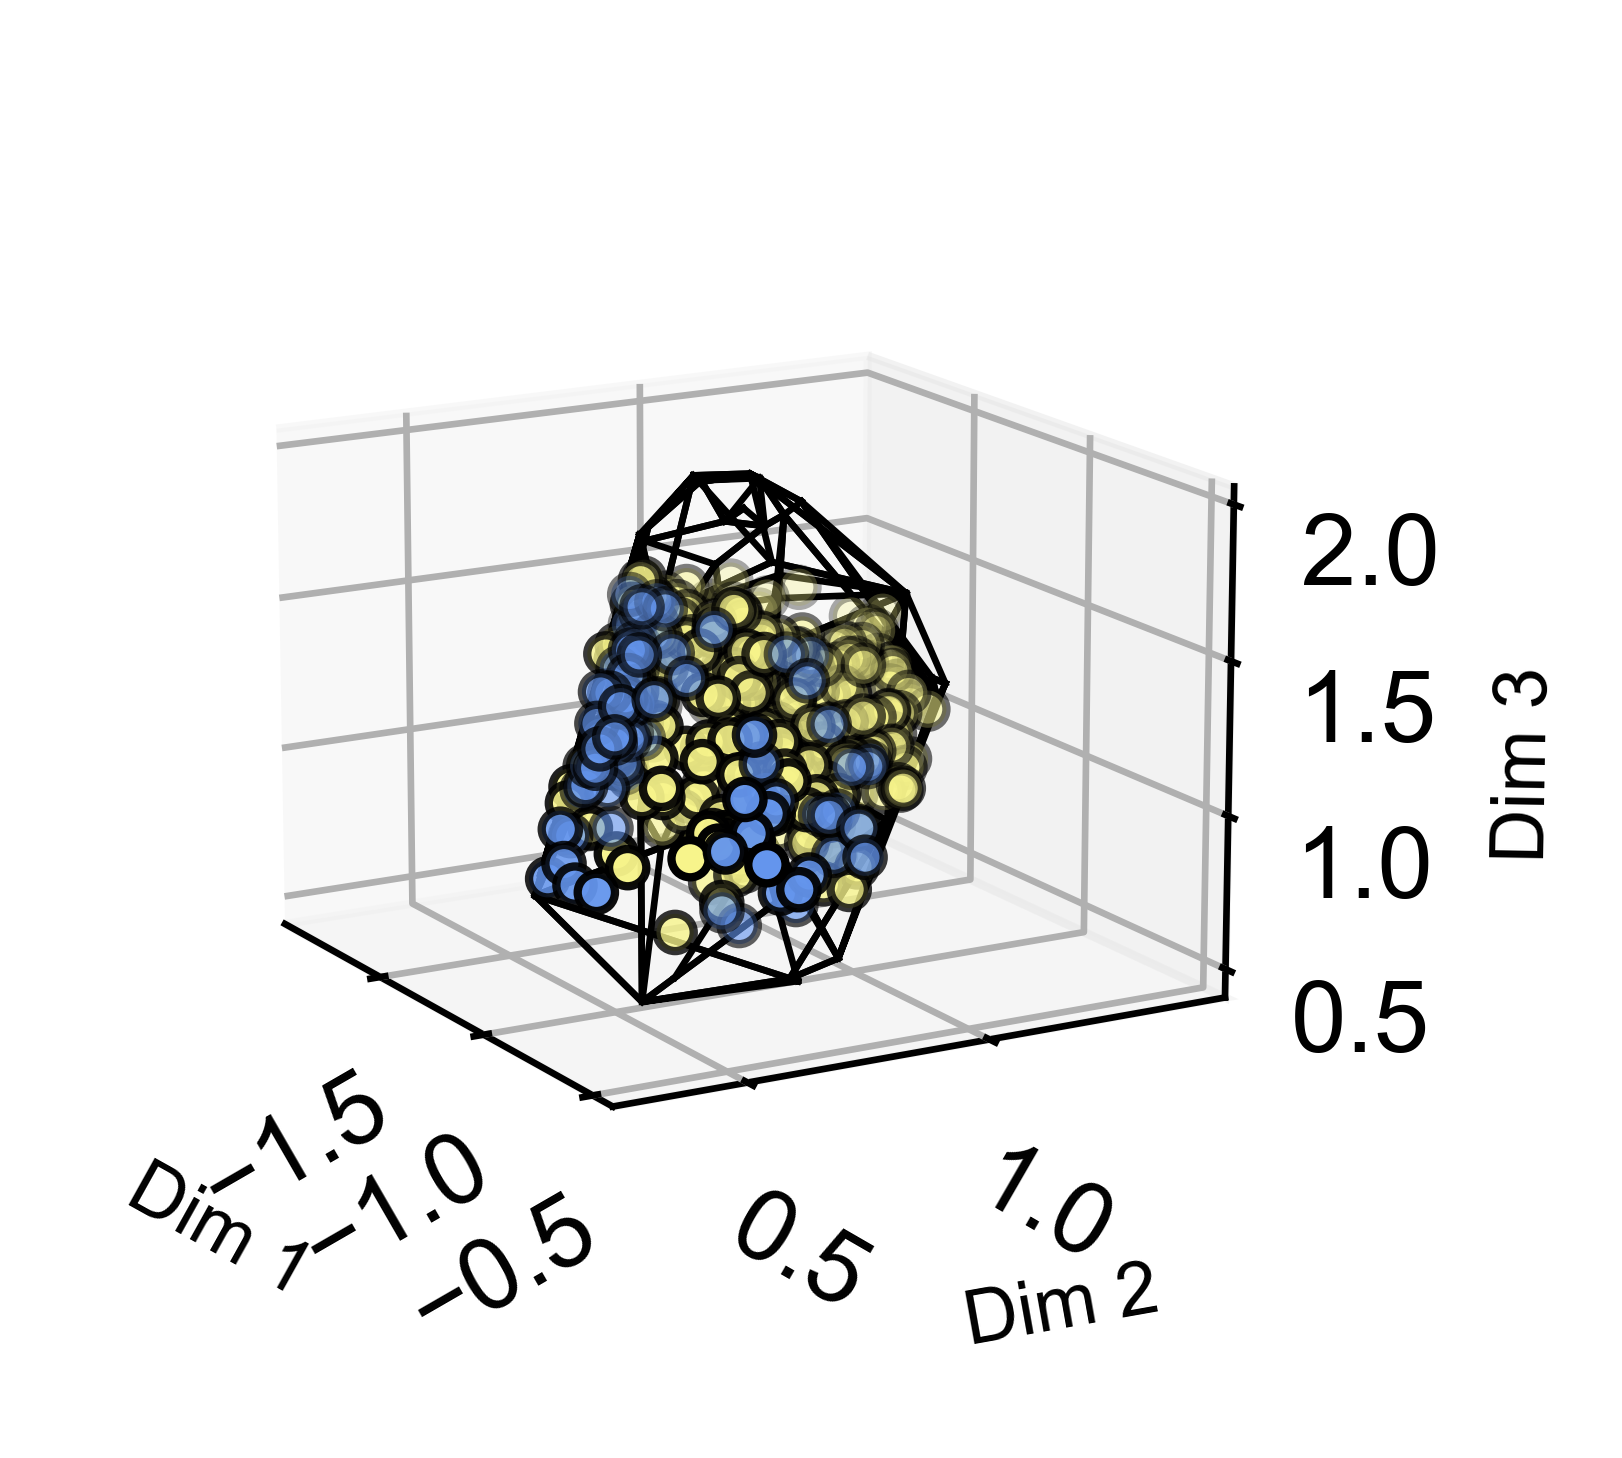

In [34]:
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)
    
    # plot functional local MMD-VAE embeddings in the convex hull
    ax.scatter(
        func_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[func_MMD_local_in_hull,0],
        func_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[func_MMD_local_in_hull,1],
        func_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[func_MMD_local_in_hull,2],
        c='#F7F48B',
        edgecolor = 'k',
        s = 20
    )
    
    # plot non-functional local MMD-VAE embeddings in the convex hull
    ax.scatter(
        nonfunc_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[nonfunc_MMD_local_in_hull,0],
        nonfunc_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[nonfunc_MMD_local_in_hull,1],
        nonfunc_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[nonfunc_MMD_local_in_hull,2],
        c='cornflowerblue',
        edgecolor = 'k',
        s = 20
    )

    for simplex in ortho_hull.simplices:
        ax.plot(
            ortho_mmd[simplex, 0],
            ortho_mmd[simplex, 1], 
            ortho_mmd[simplex, 2],
            'k-',
            lw=.8
        )

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()
#plt.savefig('figures/c.pdf')

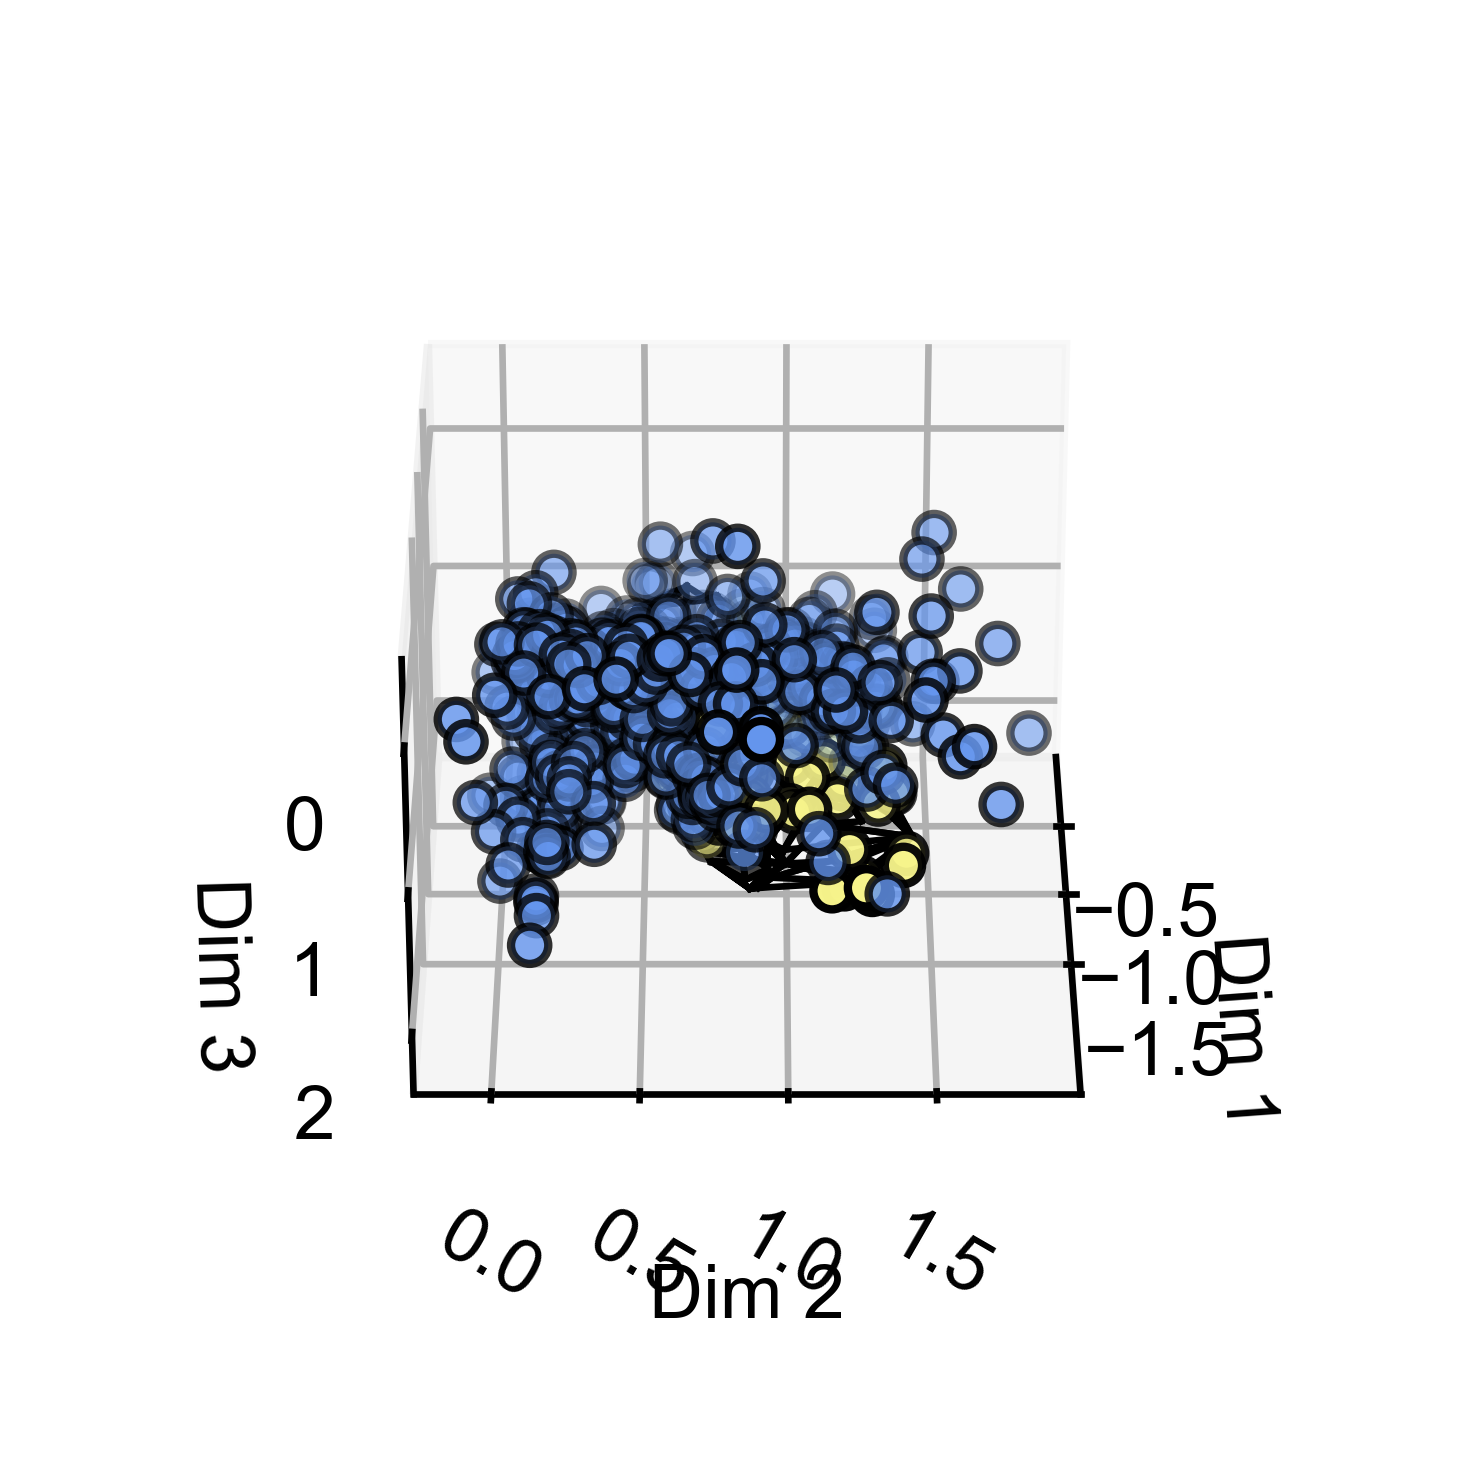

In [36]:
for fig_idx, rot_val in zip([0], [-180]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(330, rot_val)
    
    
     # plot non-functional local MMD-VAE embeddings in the convex hull
    ax.scatter(
        nonfunc_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[~nonfunc_MMD_local_in_hull,0],
        nonfunc_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[~nonfunc_MMD_local_in_hull,1],
        nonfunc_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[~nonfunc_MMD_local_in_hull,2],
        label='Training $\mathcal{L}$',
        c='cornflowerblue',
        edgecolor = 'k',
        s = 20
    )
        # plot functional local MMD-VAE embeddings in the convex hull
    ax.scatter(
        func_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[~func_MMD_local_in_hull,0],
        func_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[~func_MMD_local_in_hull,1],
        func_MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].iloc[~func_MMD_local_in_hull,2],
        label='Training $\mathcal{L}$',
        c='#F7F48B',
        edgecolor = 'k',
        s = 20
    )
    


    for simplex in ortho_hull.simplices:
        ax.plot(ortho_mmd[simplex, 0], ortho_mmd[simplex, 1],  ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=2)
    ax.set_ylabel('Dim 2', labelpad=.5)
    ax.set_zlabel('Dim 3', labelpad=1)
    ax.dist = 13.2
    #ax.tick_params(axis='x', which='major', pad=15)
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=0)
plt.tight_layout()
#plt.savefig('figures/d.pdf')
plt.show()

In [35]:
#N_nat = len(nogood_nat_mmd_coor[nofunc_class_nat==1,0]) + len(good_nat_mmd_coor[func_class_nat==1,0])
#Nf_nat = len(good_nat_mmd_coor[func_class_nat==1,0])
#r_nat = round(100*Nf_nat/N_nat,1)

#N_in = len(good_des_mmd_local_coor[fdp]) + len(nogood_des_mmd_local_coor[ufdp])
#Nf_in = len(good_des_mmd_local_coor[fdp])
#r_in = round(100*Nf_in/N_in,1)

#N_out = len(good_des_mmd_local_coor_plot[~fdp_o]) + len(nogood_des_mmd_local_coor_plot[~ufdp_o])
#Nf_out = len(good_des_mmd_local_coor_plot[~fdp_o])
#r_out = round(100*Nf_out/N_out,1)

In [36]:

# Numbers corresponding to natural ...
N_nat = sum(class_nat) # number of natural SH3 domains in the convex hulll
Nf_nat = sum(func_class_nat) # number of functional natural Sh3 domains in the convex hull
r_nat = round(100* Nf_nat / N_nat, 1)

# Numbers corresponding to local MMD-VAE ...
N_in = sum(func_MMD_local_in_hull) + sum(nonfunc_MMD_local_in_hull) # number of local MMD-VAE in the convex hull
Nf_in = sum(func_MMD_local_in_hull) # number of functional local MMD-VAE in the convex hull
r_in = round(100*Nf_in/N_in,1) # percentage

# Numbers corresponding to local MMD-VAE ...
N_out = sum(~func_MMD_local_in_hull*1) + sum(~nonfunc_MMD_local_in_hull*1) # number of local MMD-VAE outside the convex hull
Nf_out = sum(~func_MMD_local_in_hull*1) # number of functional local MMD-VAE outside the convex hull
r_out = round(100*Nf_out/N_out,1) # percentage

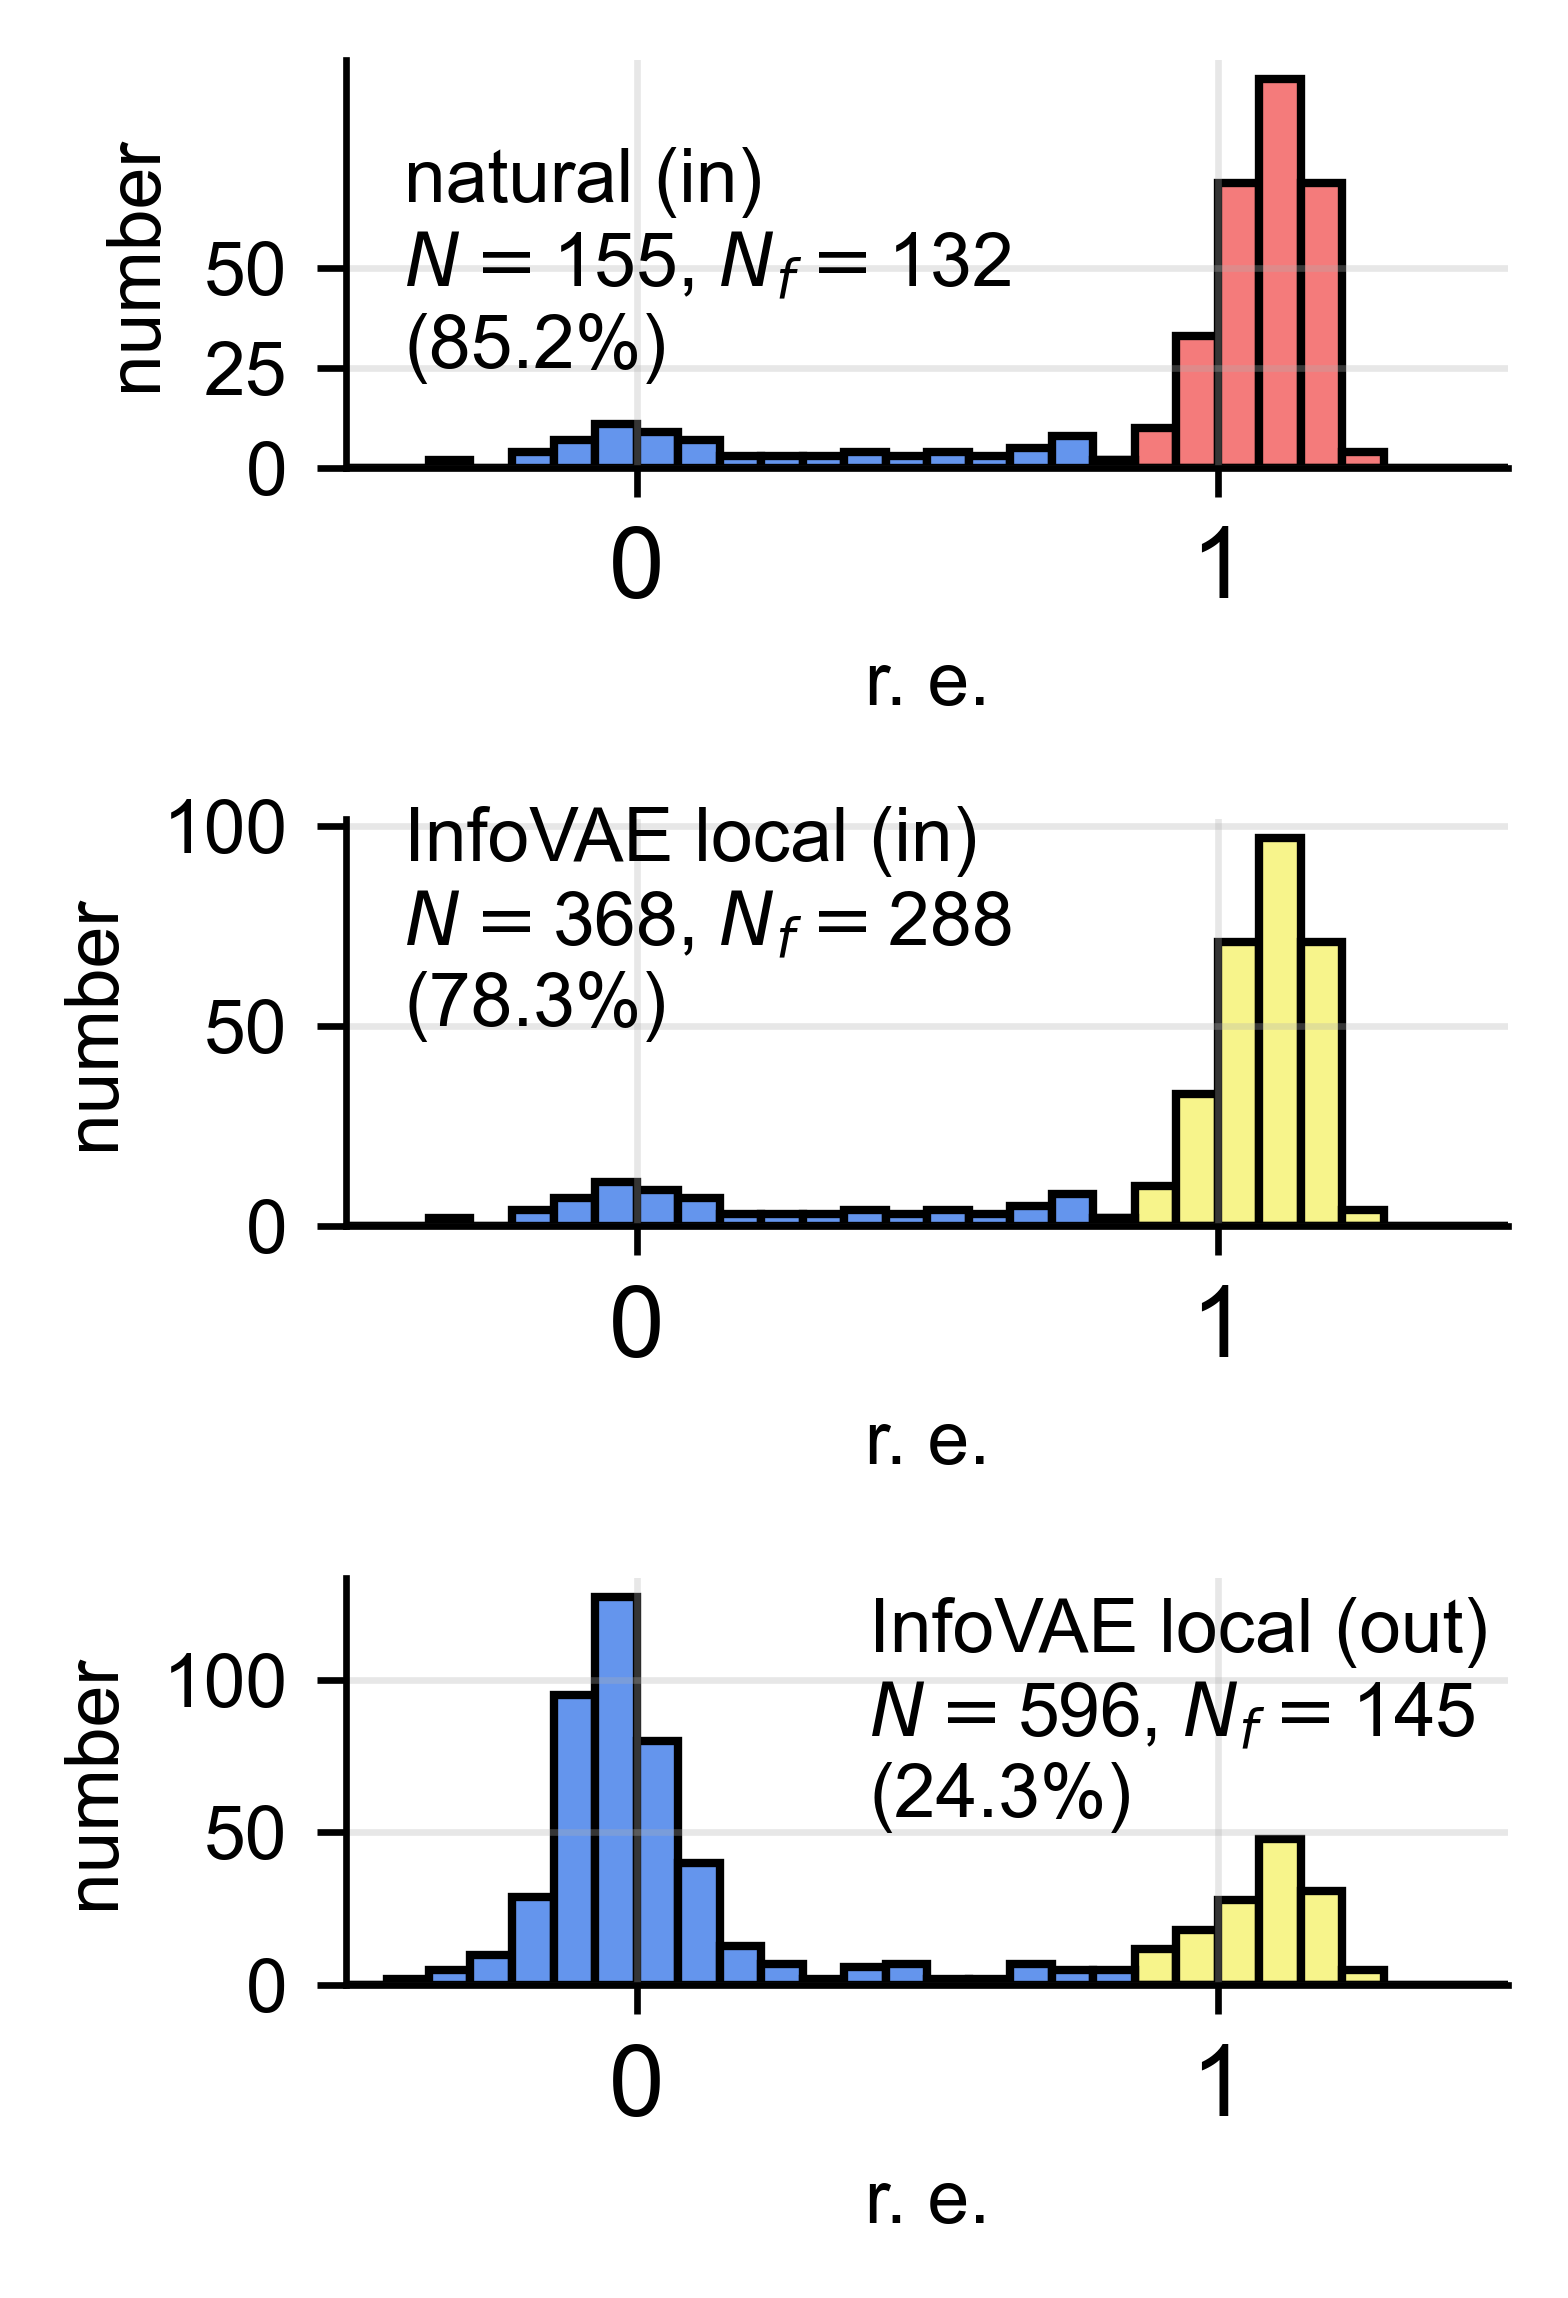

In [37]:

fig,axs=plt.subplots(3,1,figsize=[2.8,3.9],dpi=600)
patches=[0,0,0]

# plot the bimodal distribution of natural SH3 domains in the convex hull ...
# functional ...
N_hist1, bins, patches[0]=axs[0].hist(
    func_MMD_local_df.iloc[func_MMD_local_in_hull].RE_norm,
    np.linspace(-.5,1.5,29),
    color='#f47b7b',
    edgecolor='k'
)
# non-functional
N_hist1, bins, patches[0]=axs[0].hist(
    nonfunc_MMD_local_df.iloc[nonfunc_MMD_local_in_hull].RE_norm,
    np.linspace(-.5,1.5,29),
    color='cornflowerblue',
    edgecolor='k'
)

# plot the bimodal distribution of local MMD-VAE in the convex hull ...
# functional 
N_hist1, bins, patches[1]=axs[1].hist(
    func_MMD_local_df[func_MMD_local_in_hull].RE_norm,
    np.linspace(-.5,1.5,29),
    color='#F7F48B',
    edgecolor='k'
)

# nonfunctional
N_hist1, bins, patches[1]=axs[1].hist(
    nonfunc_MMD_local_df[nonfunc_MMD_local_in_hull].RE_norm,
    np.linspace(-.5,1.5,29),
    color='cornflowerblue',
    edgecolor='k'
)

# plot the bimodal distribution of local MMD-VAE outside the convex hull ...
# functional
N_hist1, bins, patches[2]=axs[2].hist(
    func_MMD_local_df[~func_MMD_local_in_hull].RE_norm,
    np.linspace(-.5,1.5,29),
    color='#F7F48B',
    edgecolor='k'
)

N_hist1, bins, patches[2]=axs[2].hist(
    nonfunc_MMD_local_df[~nonfunc_MMD_local_in_hull].RE_norm,
    np.linspace(-.5,1.5,29),
    color='cornflowerblue',
    edgecolor='k'
)

#plt.setp(axs[0].get_xticklabels(), visible=False)
#plt.setp(axs[1].get_xticklabels(), visible=False)

axs[0].set_yticks([0,25,50])
axs[1].set_yticks([0,50,100])
axs[2].set_yticks([0,50,100])
axs[0].text(-.4,25, 'natural (in)\n$N = $' + str(N_nat) + ', $N_f =$'+str(Nf_nat)+'\n('+str(r_nat)+'%)')
axs[1].text(-.4,50, 'InfoVAE local (in)\n$N = $' + str(N_in) + ', $N_f =$'+str(Nf_in)+'\n('+str(r_in)+'%)')
axs[2].text(.4,55, 'InfoVAE local (out)\n$N = $' + str(N_out) + ', $N_f =$'+str(Nf_out)+'\n('+str(r_out)+'%)')
for i in range(3):
    axs[i].set_xlabel('r. e.')
    axs[i].set_ylabel('number')
    axs[i].set_xlim(-.5,1.5)
    axs[i].grid(alpha=.3)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    for j in range(0,14):    
        patches[i][j].set_facecolor('cornflowerblue')
plt.tight_layout()
#plt.savefig('figures/rehull.pdf')
plt.show()

#### output local InfoVAE embeddings that are found in the convex hull:

In [38]:

# create design sequences (length 59)
MMD_local_df['Sequence_aligned'] = [seq[:16]+seq[18:44]+seq[45:] for seq in MMD_local_df.seq]


# determine which sequences are in the convex hull. 
MMD_local_in_hull = check_hull_list(
    MMD_local_df[[f'MMD_z{ii}' for ii in range(3)]].values,
    ortho_hull
)


# local MMD sequences in convex hull
inConvex_MMD_local_df = MMD_local_df.iloc[MMD_local_in_hull].reset_index(drop = True)

# save both the convex hull local MMD and all MMD sequences
inConvex_MMD_local_df.to_excel('.././data/LibraryDesign_LocalInfoVAE_InConvexHull.xls', index = False)
MMD_local_df.to_excel('.././data/LibraryDesign_LocalInfoVAE.xls', index = False)

<ipython-input-38-2c48e18d2107>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MMD_local_df['Sequence_aligned'] = [seq[:16]+seq[18:44]+seq[45:] for seq in MMD_local_df.seq]


In [39]:

# create design sequences (length 59)
MMD_global_df['Sequence_aligned'] = [seq[:16]+seq[18:44]+seq[45:] for seq in MMD_global_df.seq]


# determine which sequences are in the convex hull. 
MMD_global_in_hull = check_hull_list(
    MMD_global_df[[f'MMD_z{ii}' for ii in range(3)]].values,
    ortho_hull
)


# local MMD sequences in convex hull
inConvex_MMD_global_df = MMD_global_df.iloc[MMD_global_in_hull].reset_index(drop = True)

# save both the convex hull local MMD and all MMD sequences
inConvex_MMD_global_df.to_excel('.././data/LibraryDesign_GlobalInfoVAE_InConvexHull.xls', index = False)
MMD_global_df.to_excel('.././data/LibraryDesign_GlobalInfoVAE.xls', index = False)

<ipython-input-39-538589021a02>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MMD_global_df['Sequence_aligned'] = [seq[:16]+seq[18:44]+seq[45:] for seq in MMD_global_df.seq]


## Volume-ratio

In [40]:
class convex_hulls:
    """
    Method for scaling convex hull. 
    """
    
    def __init__(
        self,
        vertices,
        centroid,
        ratio
    ):
        self.vertices = centroid + (vertices - centroid) * ratio
        self.hull = ConvexHull(self.vertices)
        
    def check(self,coor):
        return check_hull_list(coor, self.hull)

# convex hull edges
vertices = ortho_mmd[ortho_hull.vertices]
#Get centoid convex hull
centroid = np.array([
    np.mean(ortho_hull.points[ortho_hull.vertices,0]),
    np.mean(ortho_hull.points[ortho_hull.vertices,1]),
    np.mean(ortho_hull.points[ortho_hull.vertices,2])
]
)

In [41]:
# different convex hulls based on scaling the original convex hull
hull1 = convex_hulls(
    vertices = vertices,
    centroid = centroid,
    ratio = 1/3
)
hull2 = convex_hulls(
    vertices = vertices,
    centroid = centroid,
    ratio = 2/3
)
hull3 = convex_hulls(
    vertices = vertices,
    centroid = centroid,
    ratio = 1
)
hull4 = convex_hulls(
    vertices = vertices,
    centroid = centroid,
    ratio = 4/3
)
hull5 = convex_hulls(
    vertices = vertices,
    centroid = centroid,
    ratio = 5/3
)
hull6 = convex_hulls(
    vertices = vertices,
    centroid = centroid,
    ratio = 2
)

hull_list = [
    hull1,
    hull2,
    hull3,
    hull4,
    hull5,
    hull6
]

In [42]:
"""
Description: assembly 2 tensors that contain all "functional natural + MMD-InfoVAE" synthetics and 
"nonfunctional natural + MMD-InfoVAE"

"""
MMD_columns = [f'MMD_z{ii}' for ii in range(3)]


# FUNCTIONAL: nat+synthetic MMD
func_nat_MMD_z = np.vstack([
    func_nat_df[MMD_columns].values,
    func_MMD_global_df[MMD_columns].values,
    func_MMD_local_df[MMD_columns].values,
]
)


# NONFUNCTIONAL: nat + synthetic MDD
nonfunc_nat_MMD_z = np.vstack([
    nonfunc_nat_df[MMD_columns].values,
    nonfunc_MMD_global_df[MMD_columns].values,
    nonfunc_MMD_local_df[MMD_columns].values,
]
)

In [43]:
print('Number of functional sequences:', func_nat_MMD_z.shape[0])
print('\nNumber of nonfunctional sequences:', nonfunc_nat_MMD_z.shape[0])

Number of functional sequences: 600

Number of nonfunctional sequences: 7635


In [44]:
func_n, nonfunc_n = [], [] # list to contain the number of func or nonfunc sequences within a specific hull

# count how many sequences are in the various hull 
for scaled_hull in hull_list:
    
    func_n.append( np.count_nonzero( scaled_hull.check( func_nat_MMD_z ) ) )
    nonfunc_n.append( np.count_nonzero( scaled_hull.check( nonfunc_nat_MMD_z ) ) )

    
# compute the number of functional embeddings in the given shell
func_shell = np.array(
    [func_n[0]] + [func_n[i]-func_n[i-1] for i in range(1,len(func_n))]
)

# compute the number of nonfunctional embeddings in the given shell
nonfunc_shell = np.array(
    [nonfunc_n[0]] + [nonfunc_n[i]-nonfunc_n[i-1] for i in range(1,len(nonfunc_n))]
)


# compute ratio of rescue embeddings relative to the total number of embeddings in a given shell
ratio = func_shell/(func_shell+nonfunc_shell)
ratio = np.round(ratio,2)

In [45]:
print('The ratio of resucing embeddings in a given shell:', list(ratio))

The ratio of resucing embeddings in a given shell: [1.0, 0.9, 0.77, 0.46, 0.06, 0.0]


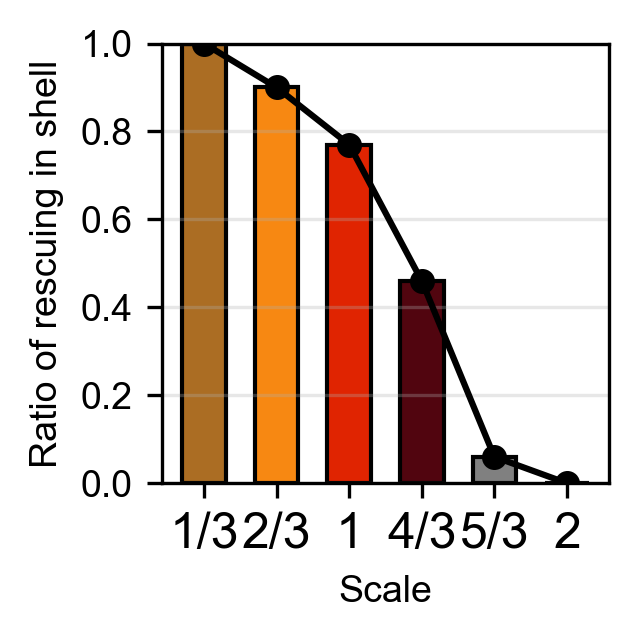

In [46]:
ratio_plot = ['1/3', '2/3', '1', '4/3', '5/3','2']
plt.figure(figsize = [2.2,2.2],dpi=300)
plt.grid(alpha=.3,axis='y')
#plt.plot([2.5,2.5],[0,1],'r--')
plt.bar(ratio_plot, ratio,edgecolor='k', width=.6, 
        color = ['#AB6D23', '#F78812', '#E02401', '#51050F','gray','lightgray'])
plt.plot(ratio_plot, ratio,'ko-', ms=5)
plt.xlabel('Scale')
plt.ylabel('Ratio of rescuing in shell')
plt.ylim([0,1])
plt.tight_layout()
#plt.savefig('figures/e2.pdf')
plt.show()

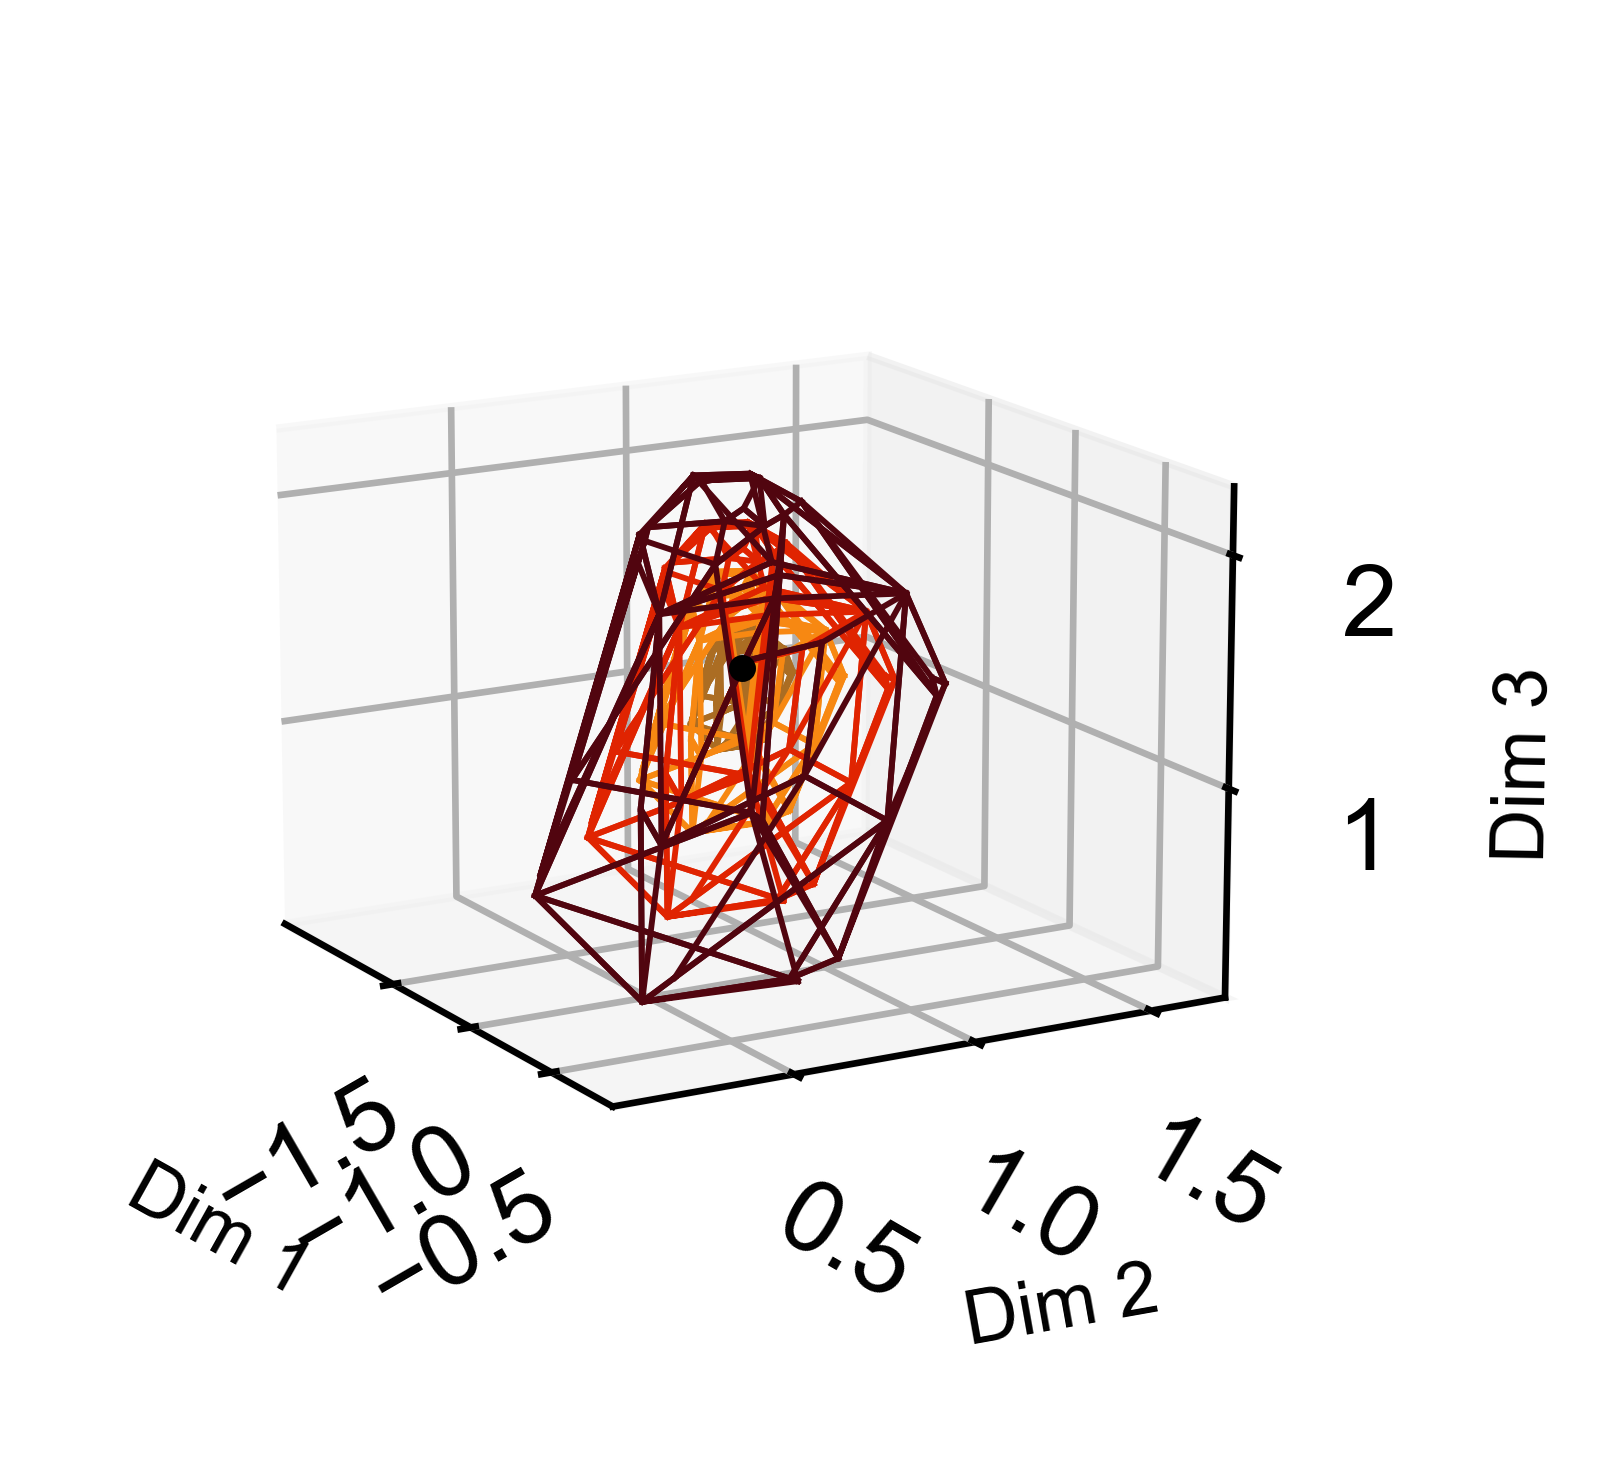

In [47]:
#clist = ['#FFC5C4','#FF7977','red','#C6C6C6','silver','gainsboro']
clist = ['#AB6D23', '#F78812', '#E02401', '#51050F']
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)
    #ax.scatter(-1.1180,0.8458,1.0742,s=5, c = 'k')
    ax.scatter(centroid[0],centroid[1],centroid[2], s = 5, c = 'k') # gmore general way of computing the centriod ..
    
    #p = ax.scatter(des_mmd_coor[:,0], des_mmd_coor[:,1], des_mmd_coor[:,2], s = 5)
    
    for num, h in enumerate(hull_list[:4]):
        for simplex in h.hull.simplices:
            ax.plot(h.vertices[simplex, 0], h.vertices[simplex, 1],  h.vertices[simplex, 2],
                    c = clist[num],lw=.7)

    #for simplex in ortho_hull.simplices:
    #    ax.plot(ortho_mmd[simplex, 0], ortho_mmd[simplex, 1],  ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()
#plt.savefig('figures/e1.pdf')

In [48]:
# FUNCTIONAL: synthetic MMD ONLY
func_MMD_z = np.vstack([
    func_MMD_global_df[MMD_columns].values,
    func_MMD_local_df[MMD_columns].values,
])

# NONFUNCTIONAL: synthetic MMD ONLY
nonfunc_MMD_z = np.vstack([
    nonfunc_MMD_global_df[MMD_columns].values,
    nonfunc_MMD_local_df[MMD_columns].values,
])



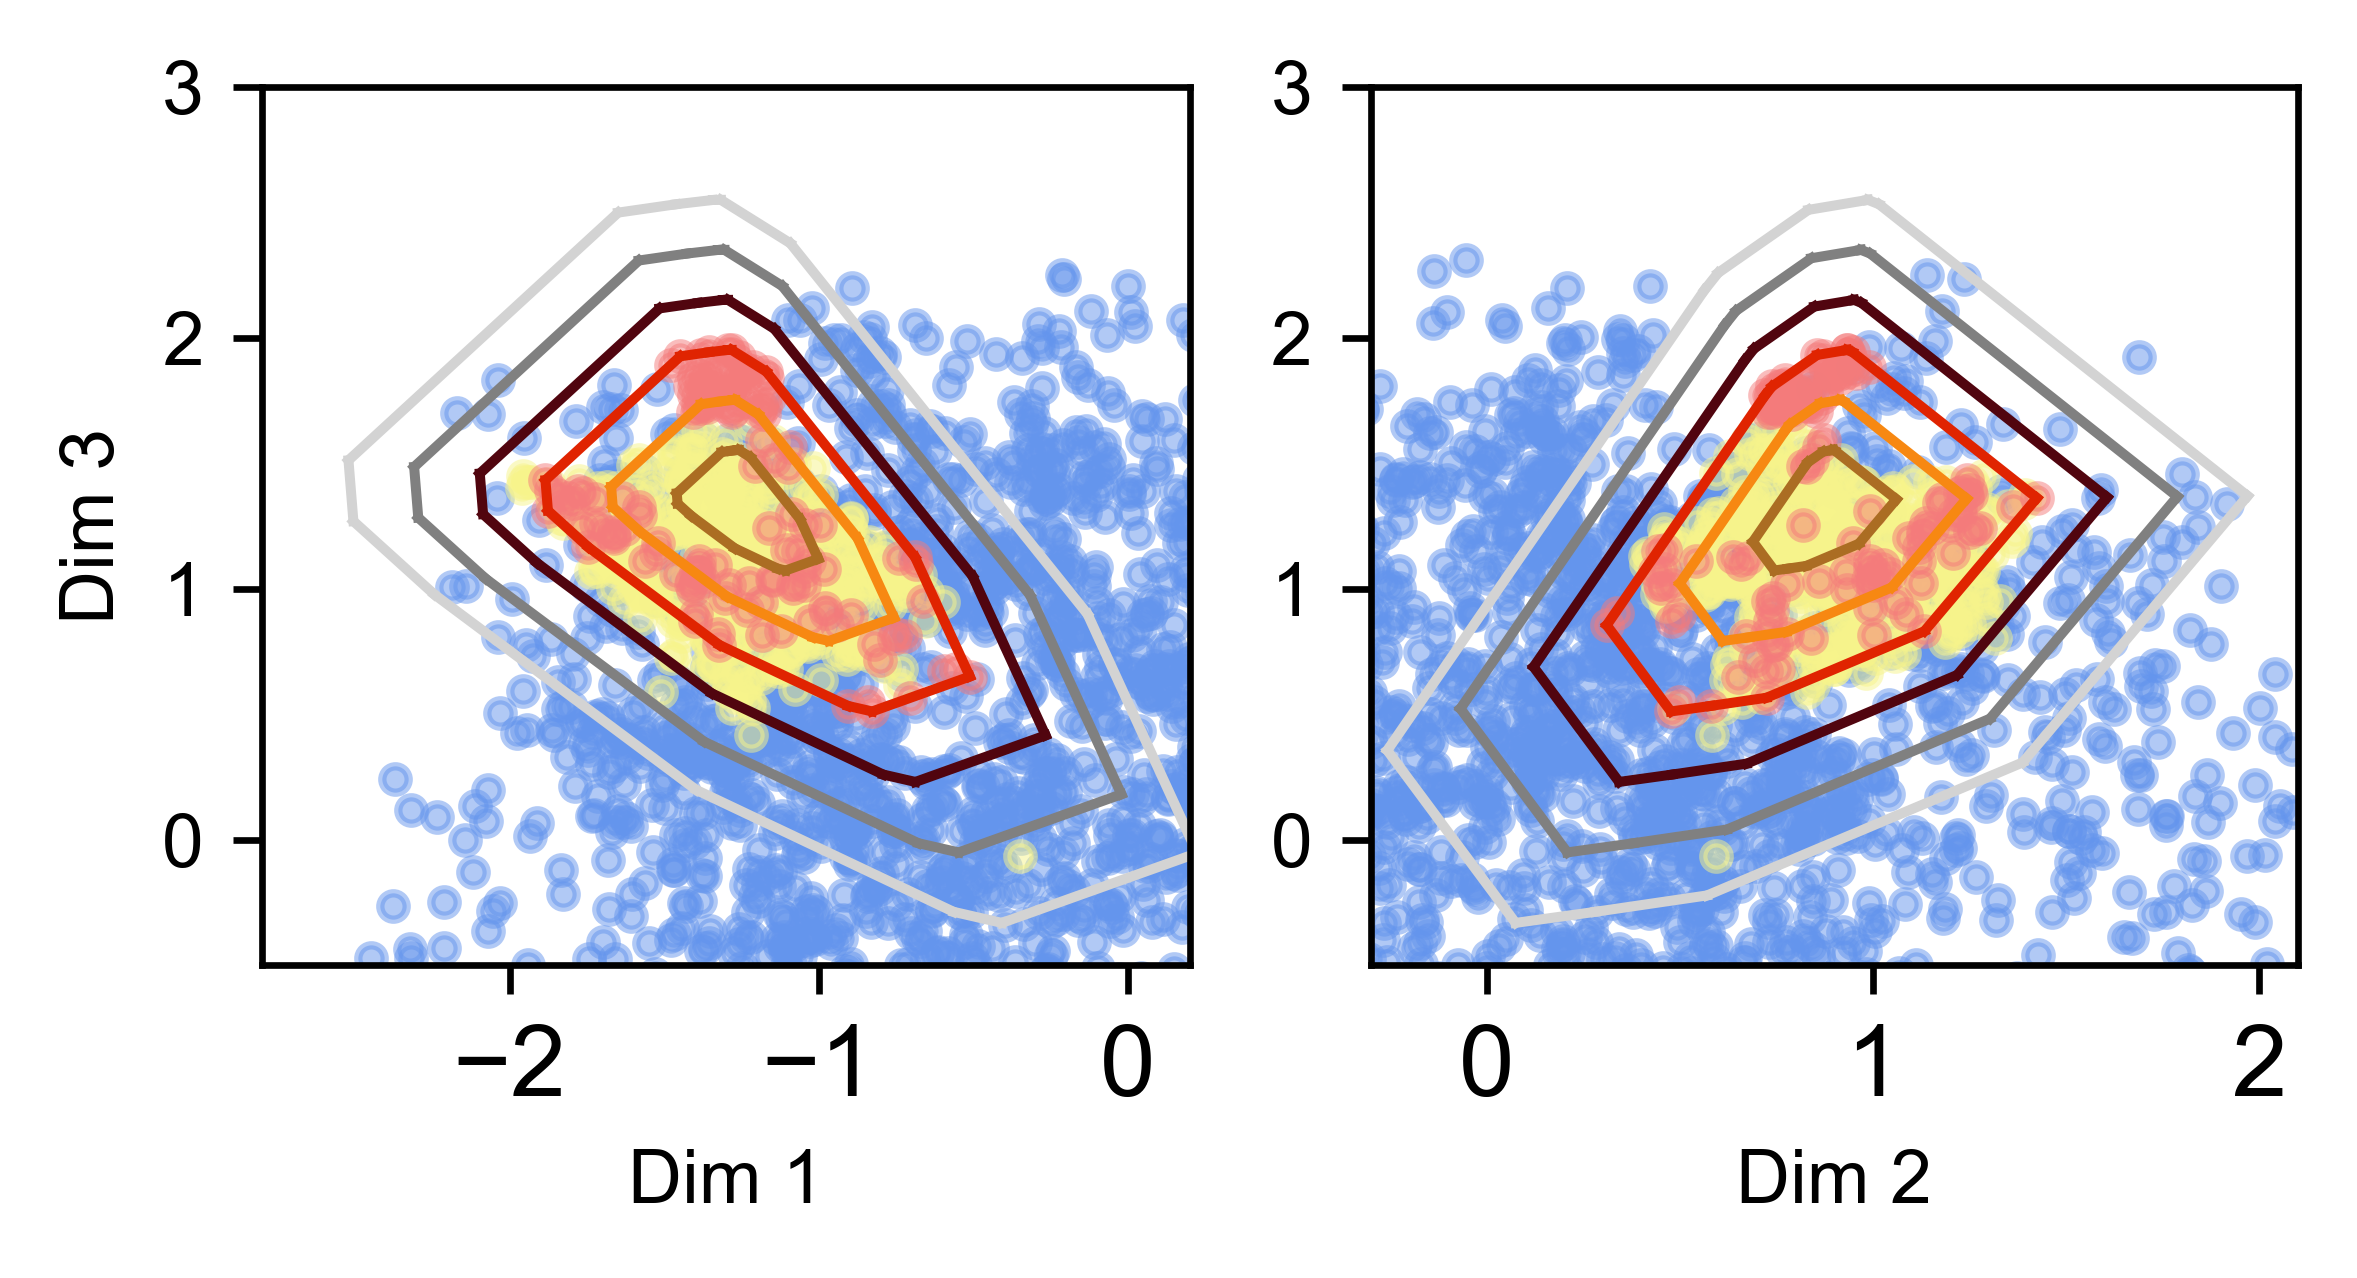

In [49]:
clist = ['#AB6D23', '#F78812', '#E02401', '#51050F','gray','lightgray']
fig, ax = plt.subplots(1,2, figsize = (4,2.2),dpi = 600)

for i, dimid in enumerate([1,2]):
    ax[i].set_xlabel('Dim '+ str(z_x[dimid]+1))
    ax[i].set_ylim(-.5,3)
    for num, h in enumerate(hull_list):
        for simplex in ConvexHull(h.vertices[:, [z_x[dimid], z_y[dimid]]]).simplices:
            ax[i].plot(h.vertices[simplex, z_x[dimid]], h.vertices[simplex, z_y[dimid]], c = clist[num],lw=1.2)

    # nonfunctional MMD-InfoVAE synthetics (global+local)
    ax[i].scatter(
        nonfunc_MMD_z[:,z_x[dimid]],
        nonfunc_MMD_z[:,z_y[dimid]], 
        c = 'cornflowerblue',
        alpha = .5,
        s = 10
    )
    
    # functional MMD-InfoVAE synthetics (global+local)
    ax[i].scatter(
        func_MMD_z[:,z_x[dimid]],
        func_MMD_z[:,z_y[dimid]], 
        c='#F7F48B', 
        alpha = .5, 
        s = 10
    )

    # functional natural (All sho1 orthologs)
    ax[i].scatter(
        func_nat_df[MMD_columns].values[:,z_x[dimid]],
        func_nat_df[MMD_columns].values[:,z_y[dimid]], 
        c='#f47b7b',
        alpha = .5,
        s = 10
    )

ax[0].set_xlim(-2.8,.2)
ax[1].set_xlim(-.3,2.1)
ax[0].set_ylabel('Dim '+ str(z_y[dimid]+1))
plt.tight_layout()
plt.savefig('figures/e3.pdf')

## Entropy

In [68]:
# all of the MMD design sequences ...
all_MMD_df = pd.concat(
    (
    func_MMD_global_df.reset_index(drop = True), 
    nonfunc_MMD_global_df.reset_index(drop = True), 
    func_MMD_local_df.reset_index(drop = True), 
    nonfunc_MMD_local_df.reset_index(drop = True),
    ),
    axis = 0
)




In [52]:
# all of the MMD design sequences ...
all_MMD_df = pd.concat(
    (
    func_MMD_global_df.reset_index(drop = True), 
    nonfunc_MMD_global_df.reset_index(drop = True), 
    func_MMD_local_df.reset_index(drop = True), 
    nonfunc_MMD_local_df.reset_index(drop = True),
    ),
    axis = 0
)



# compute how many natural sequences are found in the convex hull defined by the functional sho1s
class_nat = check_hull_list(
    nat_df[[f'MMD_z{ii}' for ii in range(3)]].values,
    ortho_hull
)

# compute how many MMD design (global+local) sequences are found in the convex hull defined by the functional sho1s
class_des_mmd_all = check_hull_list(
    all_MMD_df[[f'MMD_z{ii}' for ii in range(3)]].values,
    ortho_hull
)

inhull_seq=[SH3[i] for i in range(len(class_nat)) if class_nat[i]==1]+\
           [all_MMD_df.values[i] for i in range(len(class_des_mmd_all)) if class_des_mmd_all[i]==1]

func_seq=[SH3[i] for i in good_nat] + [designed_seq[i] for i in good_des_mmd]

all_seq=SH3.tolist()+mmd_seq

NameError: name 'mmd_all' is not defined

In [40]:
entropy_inhull = compute_entropy(inhull_seq)
entropy_func = compute_entropy(func_seq)
entropy_all = compute_entropy(all_seq)

entropy_diff = entropy_all-entropy_inhull
ediff_func = entropy_all-entropy_func

In [41]:
pos_list=np.array([2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61,62,63])

In [42]:
sho1='NFIYKAKALYPYDADDAYEISFEQNEILQVSDIEGRWWKARRNGETGIIPSNYVQLIDG'

top_n = 9
top_color_list = []
print('Top %d entropy decreasing positions (all - inhull):\n' %top_n)
for i in entropy_diff.argsort()[-top_n:]:
    print(sho1[i]+str(pos_list[i]), end = ' ')
    top_color_list.append(i)
    
print('\n')
print('Top %d entropy decreasing positions (all - func):\n' %top_n)
for i in ediff_func.argsort()[-top_n:]:
    print(sho1[i]+str(pos_list[i]), end = ' ')

Top 9 entropy decreasing positions (all - inhull):

L60 D62 D35 I52 K42 G38 G63 S55 Y5 

Top 9 entropy decreasing positions (all - func):

S24 D62 K42 I52 G38 S55 D35 Y5 G63 

In [43]:
def R2(x_values,y_values):
    correlation_matrix = np.corrcoef(x_values, y_values)
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy**2

print(R2(entropy_diff,ediff_func))

0.9496839474085979


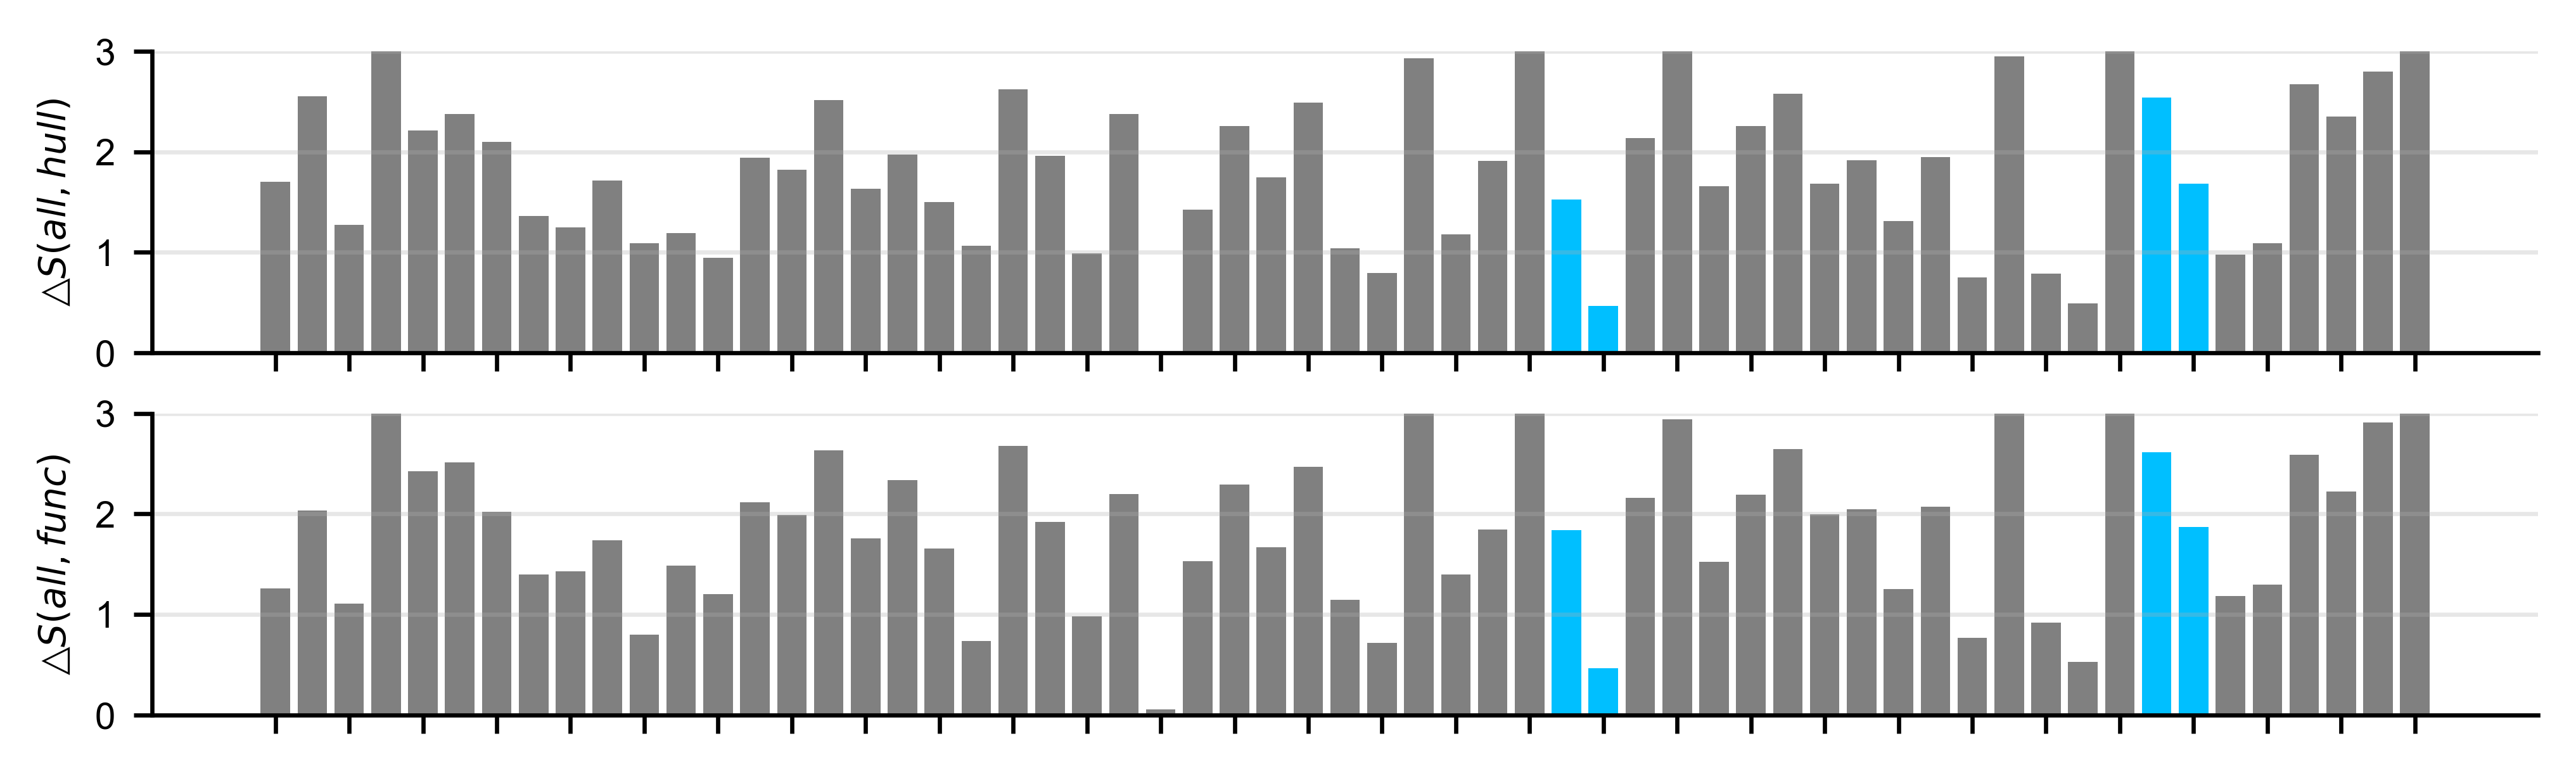

In [44]:
fig, ax = plt.subplots(2,1,figsize = [8.099,2.314],dpi=600)
bars = ax[0].bar(np.arange(59),entropy_diff,color='gray')
bars2 = ax[1].bar(np.arange(59),ediff_func,color='gray')
'''
for i in top_color_list:
    if i <55:
        bars[i].set_facecolor('orange')
        bars2[i].set_facecolor('orange')
'''
for i in [35,36,51,52]:
    bars[i].set_facecolor('deepskyblue')
    bars2[i].set_facecolor('deepskyblue')
    
ax[0].set_ylabel('$△S(all, hull)$')
ax[1].set_ylabel('$△S(all, func)$')

for i in range(2):
    ax[i].set_xticks(np.arange(0,59,2))
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].yaxis.grid(alpha=.3)
    ax[i].set_ylim([0,3])
    plt.setp(ax[i].get_xticklabels(), visible=False)
#plt.savefig('figures/entropy1.pdf')
plt.show()

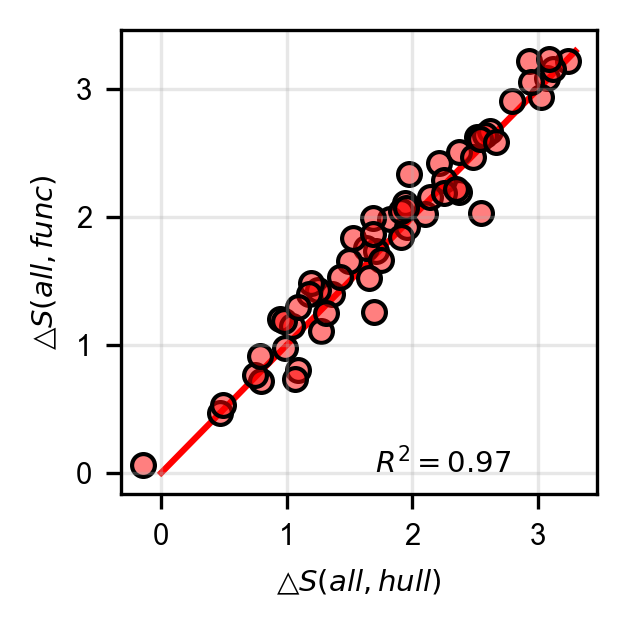

In [45]:
fig,ax = plt.subplots(1,1,figsize=[2.1,2.1],dpi=300)
ax.scatter(entropy_diff,ediff_func, edgecolor='k', facecolor=(1,.0,.0,.5), s = 30)
ax.plot([0,3.3],[0,3.3],'r',zorder=0)
plt.xlabel('$△S(all, hull)$')
plt.ylabel('$△S(all, func)$')
plt.grid(alpha=.3)
plt.text(1.7,.0,'$R^2 = 0.97$')
plt.yticks([0,1,2,3])
plt.xticks([0,1,2,3])
plt.tight_layout()
#plt.savefig('figures/entropy2.pdf')
plt.show()

## Designed sequences in InfoVAE latent space

#### Aside: reupload dataframes and merge them to plot only the 5299 natural training dataset.

In [46]:
# Natural sequences
nat_df1 = pd.read_excel('.././data/LibraryNatural.xls')
nat_df1.head()

Sequence_aligned  \
0  VFLGVYKALYDYEPQTTEELAIREDELLYLLEKSDEWWTVKKDEPV...   
1  PVINSVRALYDYDQNPDEELTFHENEEFDVYDDQDDWLLVQKTGAC...   
2  KARKEGKVLYDFIAESQDELSVKQGQTVYILNDKKDWWMCELSGQK...   
3  TGSNKNKVLFAYSKQDADEVSISLRDLVALEAADGGWTKIKNTGET...   
4  MPTRTMQAQYDYEAQGDDELSLTPNDVVNVIRGDDGWTYGE-NGEK...   

                                 Sequences_unaligned   RE_norm  \
0  TVFLGVYKALYDYEPQTTEELAIREDELLYLLEKSDVDEWWTVKKR...  0.148125   
1  APVINSVRALYDYDQAQNPDEELTFHENEEFDVYDDQDPDWLLVQQ...  0.076445   
2  SKARKEGKVLYDFIAESQDELSVKQGQTVYILNDKKSRDWWMCELV... -0.175593   
3  GTGSNKNKVLFAYSKQDADEVSISLRDLVALEAADTGSGWTKIKNL...  0.119790   
4  NMPTRTMQAQYDYEAQGDDELSLTPNDVVNVIRGDDGSGWTYGELN... -0.255056   

                                   Protein Name  \
0  Equilibrative nucleoside transporter protein   
1  Equilibrative nucleoside transporter protein   
2  Equilibrative nucleoside transporter protein   
3                Cdc42-interacting protein CIP4   
4                Cdc42-interacting protein CIP4   

                          DomainName  TranscriptID                  Species  \
0  TDEL_0F02380_domain_number[1],jgi        3708.0  Torulaspora delbrueckii   
1  TDEL_0F02380_domain_number[2],jgi        3708.0  Torulaspora delbrueckii   
2  TDEL_0F02380_domain_number[3],jgi        3708.0  Torulaspora delbrueckii   
3  TDEL_0B05220_domain_number[1],jgi        1310.0  Torulaspora delbrueckii   
4  TDEL_0B05220_domain_number[2],jgi        1310.0  Torulaspora delbrueckii   

                                           Phylogeny orthologous_group  \
0  cellular organisms; Eukaryota; Opisthokonta; F...       NOG257967_1   
1  cellular organisms; Eukaryota; Opisthokonta; F...       NOG257967_2   
2  cellular organisms; Eukaryota; Opisthokonta; F...       NOG257967_3   
3  cellular organisms; Eukaryota; Opisthokonta; F...         KOG3565_1   
4  cellular organisms; Eukaryota; Opisthokonta; F...         KOG3565_2   

   DomainNo  In Training Set  
0         1            False  
1         2            False  
2         3             True  
3         1             True  
4         2            False

In [47]:
# Natural sequences with mmd codes
nat_df2 = pd.read_excel('./data/20210908_natural_with_taxonomy.xls').iloc[:,1:]
nat_df2.head()

seq source ShortName                         DomainName  TranscriptID  \
0    0    jgi    Torde1  TDEL_0F02380_domain_number[1],jgi        3708.0   
1    1    jgi    Torde1  TDEL_0F02380_domain_number[2],jgi        3708.0   
2    2    jgi    Torde1  TDEL_0F02380_domain_number[3],jgi        3708.0   
3    3    jgi    Torde1  TDEL_0B05220_domain_number[1],jgi        1310.0   
4    4    jgi    Torde1  TDEL_0B05220_domain_number[2],jgi        1310.0   

                                        Protein  DomainNo      ID  \
0  Equilibrative nucleoside transporter protein         1  4950.0   
1  Equilibrative nucleoside transporter protein         2  4950.0   
2  Equilibrative nucleoside transporter protein         3  4950.0   
3                Cdc42-interacting protein CIP4         1  4950.0   
4                Cdc42-interacting protein CIP4         2  4950.0   

                   Species                                          Phylogeny  \
0  Torulaspora delbrueckii  cellular organisms; Eukaryota; Opisthokonta; F...   
1  Torulaspora delbrueckii  cellular organisms; Eukaryota; Opisthokonta; F...   
2  Torulaspora delbrueckii  cellular organisms; Eukaryota; Opisthokonta; F...   
3  Torulaspora delbrueckii  cellular organisms; Eukaryota; Opisthokonta; F...   
4  Torulaspora delbrueckii  cellular organisms; Eukaryota; Opisthokonta; F...   

                                           Sequences  \
0  VFLGVYKALYDYEPQTTEELAIREDELLYLLEKSDEWWTVKKDEPV...   
1  PVINSVRALYDYDQNPDEELTFHENEEFDVYDDQDDWLLVQKTGAC...   
2  KARKEGKVLYDFIAESQDELSVKQGQTVYILNDKKDWWMCELSGQK...   
3  TGSNKNKVLFAYSKQDADEVSISLRDLVALEAADGGWTKIKNTGET...   
4  MPTRTMQAQYDYEAQGDDELSLTPNDVVNVIRGDDGWTYGE-NGEK...   

                                 Sequences_unaligned    MMD_z0    MMD_z1  \
0  TVFLGVYKALYDYEPQTTEELAIREDELLYLLEKSDVDEWWTVKKR... -0.212743  0.560967   
1  APVINSVRALYDYDQAQNPDEELTFHENEEFDVYDDQDPDWLLVQQ... -0.133021  1.238067   
2  SKARKEGKVLYDFIAESQDELSVKQGQTVYILNDKKSRDWWMCELV... -1.025860  0.236221   
3  GTGSNKNKVLFAYSKQDADEVSISLRDLVALEAADTGSGWTKIKNL... -0.778632 -0.124500   
4  NMPTRTMQAQYDYEAQGDDELSLTPNDVVNVIRGDDGSGWTYGELN... -0.155759 -0.226678   

     MMD_z2                                       header_twist   norm_RE  \
0 -0.190477  4837_jgi||3708||Equilibrative nucleoside trans...  0.148125   
1 -0.209800  2997_jgi||3708||Equilibrative nucleoside trans...  0.076445   
2 -0.425561  4599_jgi||3708||Equilibrative nucleoside trans... -0.175593   
3 -0.325014  5418_jgi||1310||Cdc42-interacting protein CIP4...  0.119790   
4 -0.148836  4838_jgi||1310||Cdc42-interacting protein CIP4... -0.255056   

  orthologous_group    PhyGroup  
0       NOG257967_1  Ascomycota  
1       NOG257967_2  Ascomycota  
2       NOG257967_3  Ascomycota  
3         KOG3565_1  Ascomycota  
4         KOG3565_2  Ascomycota

In [48]:
# merge the two natural sh3 spreadsheets together 
# note: there should be both the 'In training set' and 'MMD z..' columns 
full_nat_df = nat_df1.merge( 
    nat_df2,
    left_on='Sequence_aligned', right_on='Sequences').drop_duplicates(subset='Sequences_unaligned_x').reset_index(drop = True)

train_full_nat_df = full_nat_df[full_nat_df['In Training Set']==1]
train_full_nat_df = train_full_nat_df.drop_duplicates(subset='Sequence_aligned').reset_index(drop = True)
train_full_nat_df.head()

Sequence_aligned  \
0  KARKEGKVLYDFIAESQDELSVKQGQTVYILNDKKDWWMCELSGQK...   
1  TGSNKNKVLFAYSKQDADEVSISLRDLVALEAADGGWTKIKNTGET...   
2  SPDMAIKSLHNYQAQSTKELSFSEGEFFYVVNE-EDWFLASNSGKQ...   
3  MGTLYAIVLYDFQAEKSDELTAYAGENLFICAHHNEWFIAKPLGGP...   
4  SNAPKAVALYSFAGEESGDLPFRKGDVITILKKSQDWWTGRVNGRE...   

                               Sequences_unaligned_x   RE_norm  \
0  SKARKEGKVLYDFIAESQDELSVKQGQTVYILNDKKSRDWWMCELV... -0.175593   
1  GTGSNKNKVLFAYSKQDADEVSISLRDLVALEAADTGSGWTKIKNL...  0.119790   
2  SSPDMAIKSLHNYQAQSTKELSFSEGEFFYVVNEEKDWFLASNPSS...       NaN   
3  KMGTLYAIVLYDFQAEKSDELTAYAGENLFICAHHNYEWFIAKPIG...  0.093978   
4  SSNAPKAVALYSFAGEESGDLPFRKGDVITILKKSESQDDWWTGRV...       NaN   

                                   Protein Name  \
0  Equilibrative nucleoside transporter protein   
1                Cdc42-interacting protein CIP4   
2                                 NADPH oxidase   
3                                 NADPH oxidase   
4             Uncharacterized conserved protein   

                        DomainName_x  TranscriptID_x                Species_x  \
0  TDEL_0F02380_domain_number[3],jgi          3708.0  Torulaspora delbrueckii   
1  TDEL_0B05220_domain_number[1],jgi          1310.0  Torulaspora delbrueckii   
2  TDEL_0B03070_domain_number[1],jgi          1095.0  Torulaspora delbrueckii   
3  TDEL_0B03070_domain_number[2],jgi          1095.0  Torulaspora delbrueckii   
4  TDEL_0D02240_domain_number[1],jgi          2467.0  Torulaspora delbrueckii   

                                         Phylogeny_x orthologous_group_x  \
0  cellular organisms; Eukaryota; Opisthokonta; F...         NOG257967_3   
1  cellular organisms; Eukaryota; Opisthokonta; F...           KOG3565_1   
2  cellular organisms; Eukaryota; Opisthokonta; F...           KOG4773_1   
3  cellular organisms; Eukaryota; Opisthokonta; F...           KOG4773_2   
4  cellular organisms; Eukaryota; Opisthokonta; F...             COG2930   

   DomainNo_x  ...                                        Phylogeny_y  \
0           3  ...  cellular organisms; Eukaryota; Opisthokonta; F...   
1           1  ...  cellular organisms; Eukaryota; Opisthokonta; F...   
2           1  ...  cellular organisms; Eukaryota; Opisthokonta; F...   
3           2  ...  cellular organisms; Eukaryota; Opisthokonta; F...   
4           1  ...  cellular organisms; Eukaryota; Opisthokonta; F...   

                                           Sequences  \
0  KARKEGKVLYDFIAESQDELSVKQGQTVYILNDKKDWWMCELSGQK...   
1  TGSNKNKVLFAYSKQDADEVSISLRDLVALEAADGGWTKIKNTGET...   
2  SPDMAIKSLHNYQAQSTKELSFSEGEFFYVVNE-EDWFLASNSGKQ...   
3  MGTLYAIVLYDFQAEKSDELTAYAGENLFICAHHNEWFIAKPLGGP...   
4  SNAPKAVALYSFAGEESGDLPFRKGDVITILKKSQDWWTGRVNGRE...   

                               Sequences_unaligned_y    MMD_z0    MMD_z1  \
0  SKARKEGKVLYDFIAESQDELSVKQGQTVYILNDKKSRDWWMCELV... -1.025860  0.236221   
1  GTGSNKNKVLFAYSKQDADEVSISLRDLVALEAADTGSGWTKIKNL... -0.778632 -0.124500   
2  SSPDMAIKSLHNYQAQSTKELSFSEGEFFYVVNEEKDWFLASNPSS...  0.179907  0.814722   
3  KMGTLYAIVLYDFQAEKSDELTAYAGENLFICAHHNYEWFIAKPIG...  2.446540 -0.728629   
4  SSNAPKAVALYSFAGEESGDLPFRKGDVITILKKSESQDDWWTGRV...  1.010021 -1.265780   

     MMD_z2                                       header_twist   norm_RE  \
0 -0.425561  4599_jgi||3708||Equilibrative nucleoside trans... -0.175593   
1 -0.325014  5418_jgi||1310||Cdc42-interacting protein CIP4...  0.119790   
2 -0.539496  1008_jgi||1095||NADPH oxidase ||1||4950||Torul...       NaN   
3 -0.918339  7417_jgi||1095||NADPH oxidase ||2||4950||Torul...  0.093978   
4  0.897857  2361_jgi||2467||Uncharacterized conserved prot...       NaN   

   orthologous_group_y    PhyGroup  
0          NOG257967_3  Ascomycota  
1            KOG3565_1  Ascomycota  
2            KOG4773_1  Ascomycota  
3            KOG4773_2  Ascomycota  
4              COG2930  Ascomycota  

[5 rows x 30 columns]

In [49]:
# === functional sequences defined by r.e. > 0.5 ===
func_train_full_nat_df = train_full_nat_df[train_full_nat_df.norm_RE > 0.5]
# embeddings
func_train_full_nat_z = func_train_full_nat_df[['MMD_z0', 'MMD_z1', 'MMD_z2']].values

# === nonfunctional sequences definde by r.e. <= 0.5 ===
nonfunc_train_full_nat_df = train_full_nat_df[~(train_full_nat_df.norm_RE > 0.5)]
# embeddings
nonfunc_train_full_nat_z = nonfunc_train_full_nat_df[['MMD_z0', 'MMD_z1', 'MMD_z2']].values

func_train_full_nat_z.shape, nonfunc_train_full_nat_z.shape


((162, 3), (5137, 3))

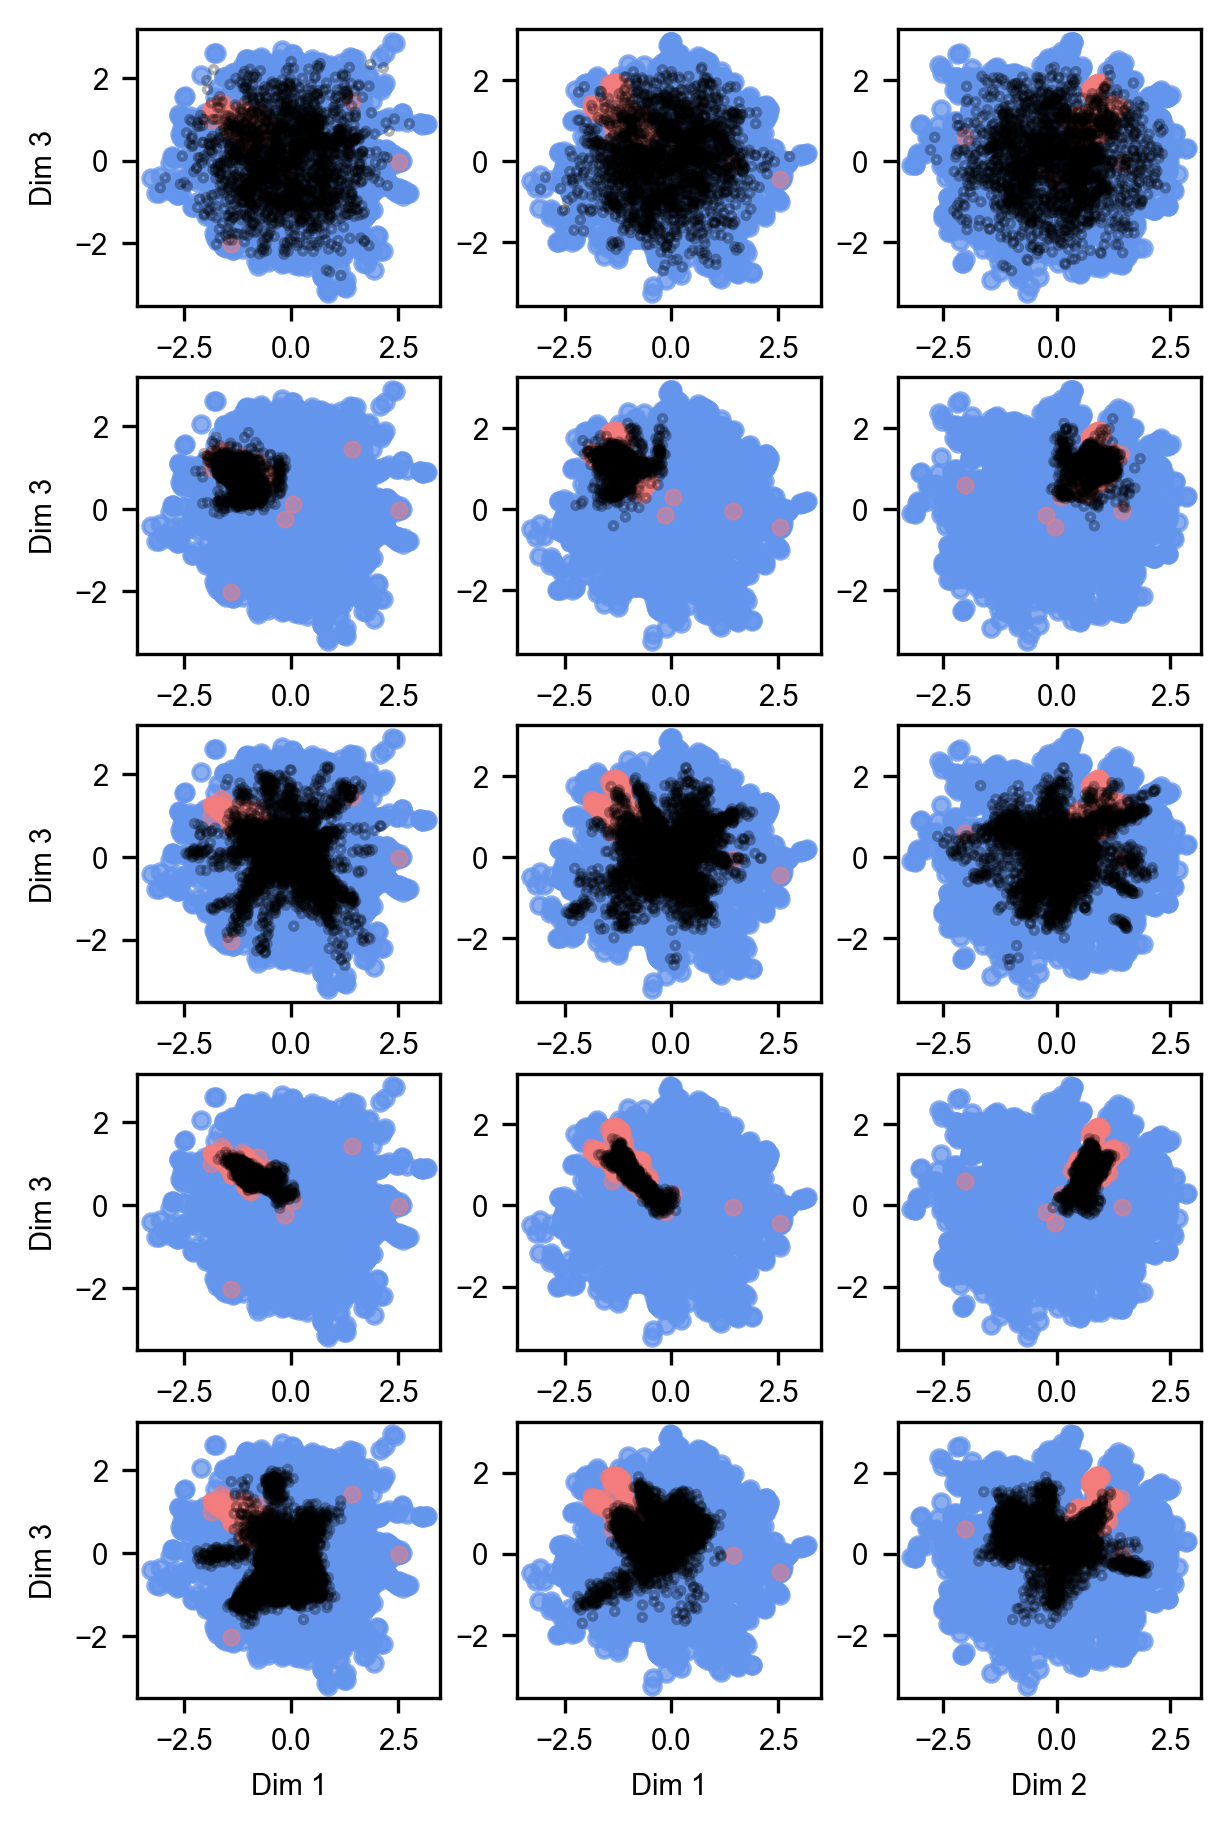

In [50]:
fig, ax = plt.subplots(5,3,figsize=(4.,6.),dpi=300)
for i in range(3):
    ax[4,i].set_xlabel('Dim '+ str(z_x[i]+1))    
    for j, mod in enumerate([mmd_global, mmd_local, VAE_global, VAE_local, bm]):
        
        # functional latent embeddings
        ax[j,i].scatter(nonfunc_train_full_nat_z[:,z_x[i]], nonfunc_train_full_nat_z[:,z_y[i]]
                   ,s=size, c = 'cornflowerblue',alpha=.5)

        ax[j,i].scatter(func_train_full_nat_z[:,z_x[i]], func_train_full_nat_z[:,z_y[i]],
                  c = '#f47c7c', linewidth=lw,s = size,alpha=.5 )

        # nonfunctional latent embeddings
        ax[j,i].scatter(nonfunc_train_full_nat_z[:,z_x[i]], nonfunc_train_full_nat_z[:,z_y[i]]
                                              ,s=size, c = 'cornflowerblue',alpha=.5)
        ax[j,i].scatter(func_train_full_nat_z[:,z_x[i]], func_train_full_nat_z[:,z_y[i]],
                  c = '#f47c7c', linewidth=lw,s = size,alpha=.5)

        
      #  ax[j,i].scatter(mmd_nat_coord[nogood_nat,z_x[i]], mmd_nat_coord[nogood_nat,z_y[i]],
      #                  s=3, c = 'cornflowerblue',alpha=.5)
      #  ax[j,i].scatter(mmd_nat_coord[good_nat[:],z_x[i]], mmd_nat_coord[good_nat[:],z_y[i]],
      #                  s=3, c = '#f47b7b',alpha = .5)
        ax[j,i].scatter(design_mmd[mod,z_x[i]], design_mmd[mod,z_y[i]],s=3, 
                     alpha = .3, facecolors='none', edgecolors='k')
        ax[j,0].set_ylabel('Dim '+ str(z_y[i]+1))
plt.tight_layout(pad=.5)
#plt.savefig('./figures/sample.svg', dpi = 300)
#plt.savefig('./figures/sample.svg', dpi = 300)
plt.show()